# Analisis exploratorio

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

from pytorch_common.util import LoggerBuilder

import numpy as np
import pandas as pd

from data.missing import MissingsManager
import data as dt
import data.plot as pl
import util as ut

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

## Carga de dataset

1. Importamos los archivos de peliculas y ratings preprocesados previamente en mongodb:

In [4]:
DATASETS_PATH   = '../datasets'

movies          = pd.read_json(f'{DATASETS_PATH}/movies_v3.json')
interactions    = pd.read_json(f'{DATASETS_PATH}/ratings_tags_v1.json')

In [5]:
interactions = interactions.drop('_id', axis=1)


movies['id']  = movies['_id']
movies  = movies.drop(['_id', 'tmdb_id'], axis=1)
movies['release'] = pd.to_datetime(movies['release'], format='%Y-%m-%d')

In [6]:
interactions.dtypes

rating              float64
timestamp    datetime64[ns]
user_id               int64
movie_id              int64
tags                 object
dtype: object

In [7]:
movies.dtypes

imdb_id                       int64
title                        object
genres                       object
for_adults                   object
budget                        int64
original_language            object
overview                     object
poster                       object
release              datetime64[ns]
popularity                  float64
vote_mean                   float64
vote_count                  float64
tags                         object
id                            int64
dtype: object

In [8]:
interactions.head()

rating 
 timestamp 
 user_id 
 movie_id 
 tags 
 
 
 
 
 0 
 4.0 
 2015-08-13 13:23:59 
 3 
 260 
 [classic, sci-fi] 
 
 
 1 
 4.5 
 2019-11-16 22:33:10 
 4 
 1732 
 [dark comedy, great dialogue] 
 
 
 2 
 3.5 
 2019-11-16 22:30:31 
 4 
 7569 
 [so bad it's good] 
 
 
 3 
 5.0 
 2019-11-16 21:10:28 
 4 
 44665 
 [unreliable narrators] 
 
 
 4 
 2.0 
 2019-11-16 22:22:35 
 4 
 148426 
 [so bad it's good]

In [9]:
movies.head()

imdb_id 
 title 
 genres 
 for_adults 
 budget 
 original_language 
 overview 
 poster 
 release 
 popularity 
 vote_mean 
 vote_count 
 tags 
 id 
 
 
 
 
 0 
 113497 
 Jumanji 
 [Adventure, Children, Fantasy] 
 False 
 65000000 
 en 
 When siblings Judy and Peter discover an encha... 
 /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg 
 1995-12-15 
 17.015539 
 6.9 
 2413.0 
 [adaptation of book, adapted from:book, advent... 
 2 
 
 
 1 
 113228 
 Grumpier Old Men 
 [Comedy, Romance] 
 False 
 0 
 en 
 A family wedding reignites the ancient feud be... 
 /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg 
 1995-12-22 
 11.712900 
 6.5 
 92.0 
 [ann margaret, best friend, burgess meredith, ... 
 3 
 
 
 2 
 114885 
 Waiting to Exhale 
 [Comedy, Drama, Romance] 
 False 
 16000000 
 en 
 Cheated on, mistreated and stepped on, the wom... 
 /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg 
 1995-12-22 
 3.859495 
 6.1 
 34.0 
 [based on novel or book, characters, chick fli... 
 4 
 
 
 3 
 113041 
 Father of the Bride Part II 
 [Comedy] 
 False 
 0 
 en 
 Just when George Banks has recovered from his ... 
 /e64sOI48hQXyru7naBFyssKFxVd.jpg 
 1995-02-10 
 8.387519 
 5.7 
 173.0 
 [aging, baby, clv, comedy, confidence, contrac... 
 5 
 
 
 4 
 113277 
 Heat 
 [Action, Crime, Thriller] 
 False 
 60000000 
 en 
 Obsessive master thief, Neil McCauley leads a ... 
 /zMyfPUelumio3tiDKPffaUpsQTD.jpg 
 1995-12-15 
 17.924927 
 7.7 
 1886.0 
 [1, 7.5-filmaffinity, action, adultery, al and... 
 6

## Valores faltantes

### Movies

Configuramos un instancia de **MissingsManager** con reglas que toman los ceros como valores faltantes para la variable budget, vote_mean y vote_count.

In [10]:
mm = MissingsManager() \
    .add_rule_fn('popularity', lambda v: v <= 0) \
    .add_rule_fn('budget', lambda v: v <= 0) \
    .add_rule_fn('vote_mean', lambda v: v <= 0) \
    .add_rule_fn('vote_count', lambda v: v <= 0)

movies.pipe(mm.report)

Column 
 Percent (%) 
 Count 
 rule 
 indexes 
 
 
 
 
 0 
 budget 
 0.772227 
 27143 
 CustomMissingFnRule 
 [1, 3, 6, 8, 17, 20, 22, 23, 25, 27, 29, 30, 3... 
 
 
 1 
 poster 
 0.000085 
 3 
 ColumnMissingValueRule 
 [17418, 24461, 28566] 
 
 
 2 
 release 
 0.000854 
 30 
 ColumnMissingValueRule 
 [15246, 15319, 17418, 17672, 20289, 22983, 244... 
 
 
 3 
 popularity 
 0.000541 
 19 
 CustomMissingFnRule 
 [5356, 15246, 17672, 17787, 18106, 18796, 2301... 
 
 
 4 
 vote_mean 
 0.048024 
 1688 
 CustomMissingFnRule 
 [96, 114, 121, 151, 377, 381, 383, 529, 540, 5... 
 
 
 5 
 vote_count 
 0.045833 
 1611 
 CustomMissingFnRule 
 [96, 114, 121, 151, 377, 381, 383, 540, 541, 5...

Removemos las filas del dataset para aquellas columnas del reporte de valores faltantes que tengan una cantida de hasta 0.06 % de valores faltantes:

In [11]:
movies2 = movies.pipe(mm.remove_rows, max_missings=0.06)

2023-02-06 17:57:55,063 - INFO - Remove rows for columns <= 0.06 % of missings values.


In [12]:
movies2.pipe(mm.report)

Column 
 Percent (%) 
 Count 
 rule 
 indexes 
 
 
 
 
 0 
 budget 
 0.762289 
 25494 
 CustomMissingFnRule 
 [1, 3, 6, 8, 17, 20, 22, 23, 25, 27, 29, 30, 3...

De esta forma, borramos todas las filas con missing values en columnas con un porcentaje de missing <= 0.06, quedandonos solamente una columna con un porcentaje mayor de missing values. Esta columna no se puede utilizar en el entrenamiento, ya que tiene 70% de missing values. Por esta cuestion optamos por removerla del dataset.

In [13]:
movies3 = movies2.pipe(mm.remove_columns, max_percent=0.4)

2023-02-06 17:57:56,590 - INFO - Remove columns with missing >= 0.4 %


In [14]:
movies3.pipe(mm.report)

Column 
 
 
 
 
 0 
 Not found columns with missing values

Finalemente obtenemos un dataset sin missings.

In [15]:
movies3.head()

imdb_id 
 title 
 genres 
 for_adults 
 original_language 
 overview 
 poster 
 release 
 popularity 
 vote_mean 
 vote_count 
 tags 
 id 
 
 
 
 
 0 
 113497 
 Jumanji 
 [Adventure, Children, Fantasy] 
 False 
 en 
 When siblings Judy and Peter discover an encha... 
 /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg 
 1995-12-15 
 17.015539 
 6.9 
 2413.0 
 [adaptation of book, adapted from:book, advent... 
 2 
 
 
 1 
 113228 
 Grumpier Old Men 
 [Comedy, Romance] 
 False 
 en 
 A family wedding reignites the ancient feud be... 
 /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg 
 1995-12-22 
 11.712900 
 6.5 
 92.0 
 [ann margaret, best friend, burgess meredith, ... 
 3 
 
 
 2 
 114885 
 Waiting to Exhale 
 [Comedy, Drama, Romance] 
 False 
 en 
 Cheated on, mistreated and stepped on, the wom... 
 /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg 
 1995-12-22 
 3.859495 
 6.1 
 34.0 
 [based on novel or book, characters, chick fli... 
 4 
 
 
 3 
 113041 
 Father of the Bride Part II 
 [Comedy] 
 False 
 en 
 Just when George Banks has recovered from his ... 
 /e64sOI48hQXyru7naBFyssKFxVd.jpg 
 1995-02-10 
 8.387519 
 5.7 
 173.0 
 [aging, baby, clv, comedy, confidence, contrac... 
 5 
 
 
 4 
 113277 
 Heat 
 [Action, Crime, Thriller] 
 False 
 en 
 Obsessive master thief, Neil McCauley leads a ... 
 /zMyfPUelumio3tiDKPffaUpsQTD.jpg 
 1995-12-15 
 17.924927 
 7.7 
 1886.0 
 [1, 7.5-filmaffinity, action, adultery, al and... 
 6

In [16]:
movie_missings_percent = 1 - (len(movies3) / len(movies))

print(f'El porcentaje filas con valores faltantes en la tabla movies es del {movie_missings_percent:.2f} %')

El porcentaje filas con valores faltantes en la tabla movies es del 0.05 %

### Interactions

In [17]:
mm = MissingsManager() \
    .add_rule_fn('tags', lambda v: len(v) == 0) \
    .add_rule_fn('rating', lambda v: v < 0.5)

interactions.pipe(mm.report)

Column 
 
 
 
 
 0 
 Not found columns with missing values

Renombramos la tabla ratings como interactions, ya que esta representa la acción que realiza un usuario al clasificar una pelicula. Ademas, se registra el momento del evento y por otro lado tenemos los tags que cargo el mismo usaurio a la pelicula pelicula clasificada. 

Para chequear faltantes agregarmos dos reglas extra:

- Si la columna tags no tiene valores (Cada valor es una colección), se toma con un valor faltante.
- Si tenemos ratings menores a 0.5, los tomamos con un valor faltante.

Finalmente, se peude aprecia que el reporte de missing values no muestra columnas con valores faltantes.

## ¿Con que número de peliculas y usuarios contamos?

**Peliculas:**

In [18]:
len(np.unique(movies3.id.values))

33444

**Usuarios que calificaron peliculas**: No es lo mismo que el total de usuarios. Esto son los usuarios quw al menos calificaron una pelicula.

In [19]:
len(np.unique(interactions.user_id.values))

13281

**Cantidad de peliculas calificadas por al menos un usuario:**

In [20]:
len(np.unique(interactions.movie_id.values))

22082

## Variables

A continacion analizamos cada variable en ambas tablas.

### Movies

A continaución analizamos cada variable de la tabla movies.

In [21]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35149 entries, 0 to 35148
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   imdb_id            35149 non-null  int64         
 1   title              35149 non-null  object        
 2   genres             35149 non-null  object        
 3   for_adults         35149 non-null  object        
 4   budget             35149 non-null  int64         
 5   original_language  35149 non-null  object        
 6   overview           35149 non-null  object        
 7   poster             35146 non-null  object        
 8   release            35119 non-null  datetime64[ns]
 9   popularity         35146 non-null  float64       
 10  vote_mean          35146 non-null  float64       
 11  vote_count         35146 non-null  float64       
 12  tags               35149 non-null  object        
 13  id                 35149 non-null  int64         
dtypes: dat

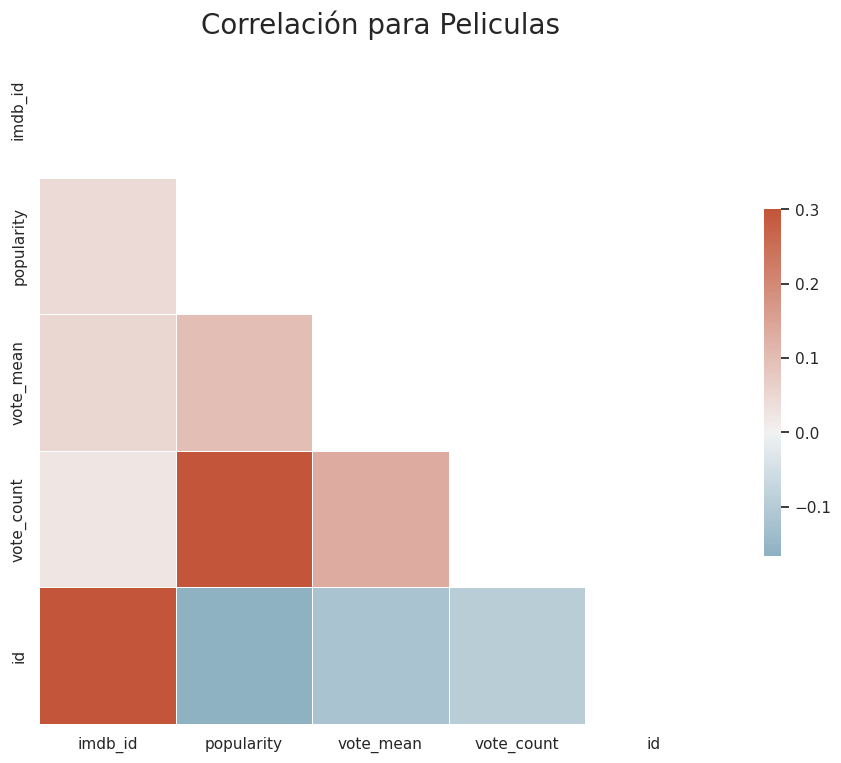

In [22]:
pl.correlations(
    movies3, 
    title='Correlación para Peliculas'
)

#### Popilarity

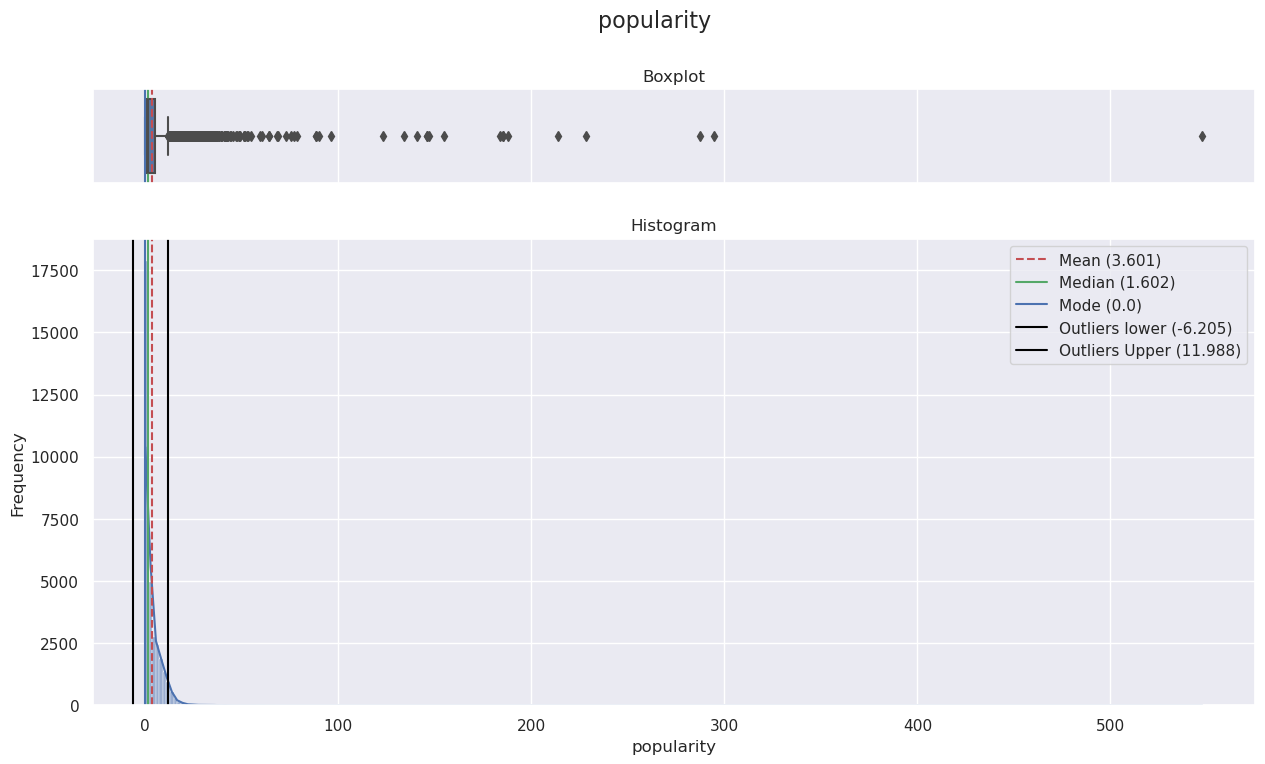

In [23]:
pl.l_size()
pl.describe_num_var(movies3, "popularity", bins=300)

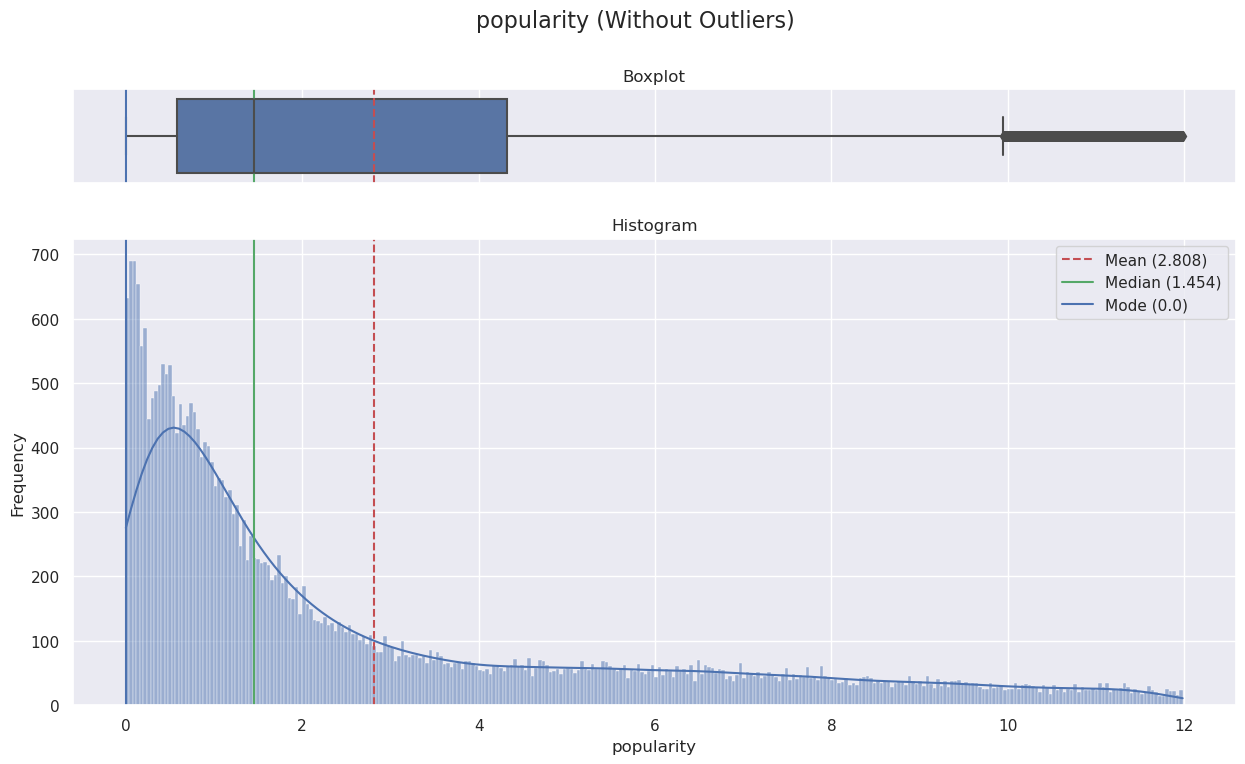

In [24]:
pl.describe_num_var(movies3, "popularity", bins=300, remove_outliers=True)

**Observaciones**

* La popularidad mantiene la relación de una ley de potencias, donde pocas peliculas son muy populares siendo en su mayoria valores atipicos, por encima de bigote superior o maximo y muchas peliculas tiene valores bajs de popularidad.
* Si quitams todos los valores > Q3+1.5*IQR y < Q1-1.5*IQR vemos con mas claridad una distribucion sesgadda a derecha y por ende la mediana y media a izquierda.
* La mode se encuetra en el cero. Esto nos dice que la mayoria de peliculas tiene popularidad cero.

### For Adults

¿La pelicula esta catalogada para mayores de edad? 

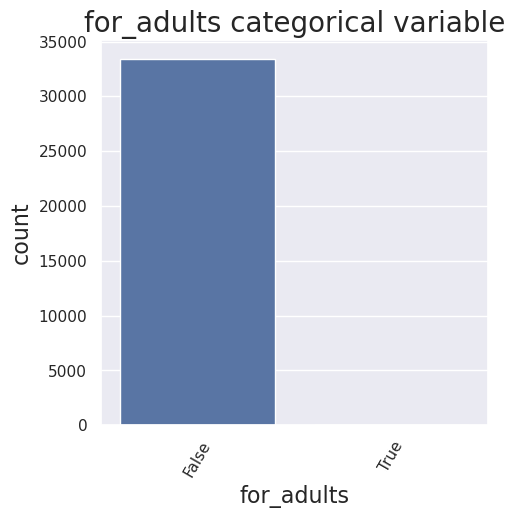

In [25]:
pl.s_size()
pl.describe_cat_var(movies3, "for_adults")

**Observaciones**

* Se aprecia que esta variable esta muy desbalanceada. 
* Ademas es inconsistente, ya que de 33.444 peliculas solo 6 son para adultos. Por esta cuestión esta columna no es apto para el entrenamiento y se decidio removerla.

### Release

Se refiere a la fecha de estreno de la pelicula.

In [26]:
movies3['release_year'] = movies3.release.dt.year

In [27]:
movies3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33444 entries, 0 to 35148
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   imdb_id            33444 non-null  int64         
 1   title              33444 non-null  object        
 2   genres             33444 non-null  object        
 3   for_adults         33444 non-null  object        
 4   original_language  33444 non-null  object        
 5   overview           33444 non-null  object        
 6   poster             33444 non-null  object        
 7   release            33444 non-null  datetime64[ns]
 8   popularity         33444 non-null  float64       
 9   vote_mean          33444 non-null  float64       
 10  vote_count         33444 non-null  float64       
 11  tags               33444 non-null  object        
 12  id                 33444 non-null  int64         
 13  release_year       33444 non-null  int64         
dtypes: dat

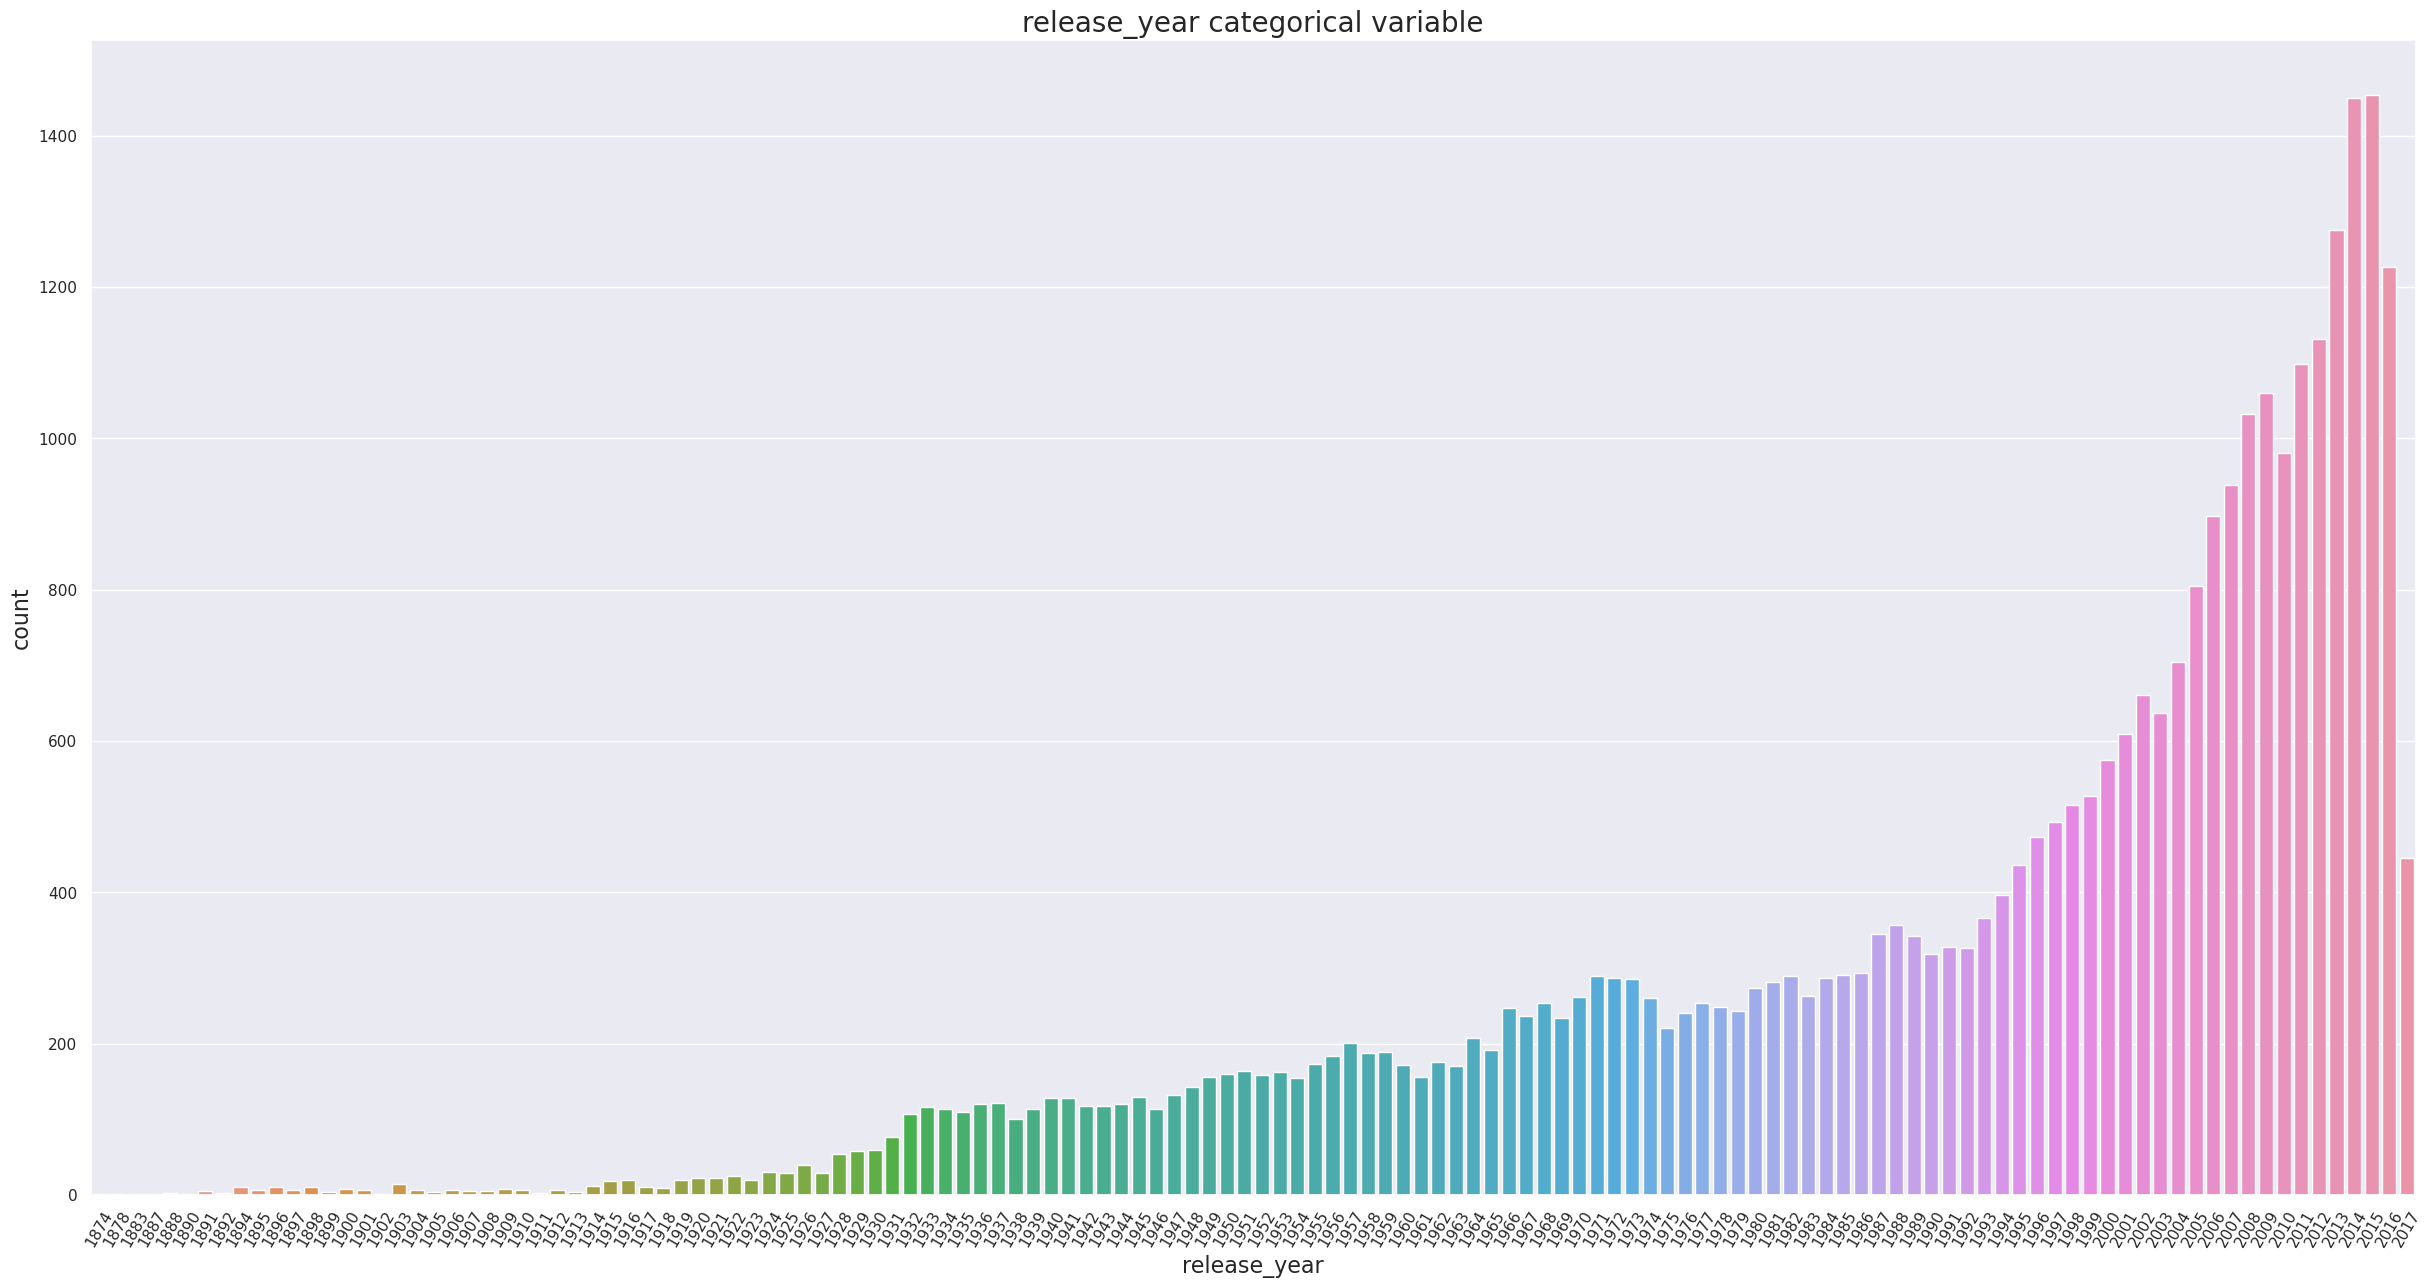

In [28]:
pl.xxl_size()
pl.describe_cat_var(movies3, 'release_year', order_column='release_year')

**Observaciones**

* Acalramos que hay una icinsitencia de datos. Hay años como 2005 donde el primero de enero tiene todos los estrenso de año y otros deonde los estrenos estan repartidos en varias fechas. Esto nos dice que es posible que en realidad este campo represente la cantidad de pelicula extrenada por año o bien que esa sea la cardinalidad real de los datos.
* Por otro lado en el grafico se aprecia que la cantidad de peliculas estrenada por año crese exponencialmente y 2017 baja lo cual seguramente es decido a que no se encuentra todo el año.
* A partor del 1994 se aprecia in el mayor crecimiento.

### Original Language

Se refiere al lenguage del audio original de la pelicula.

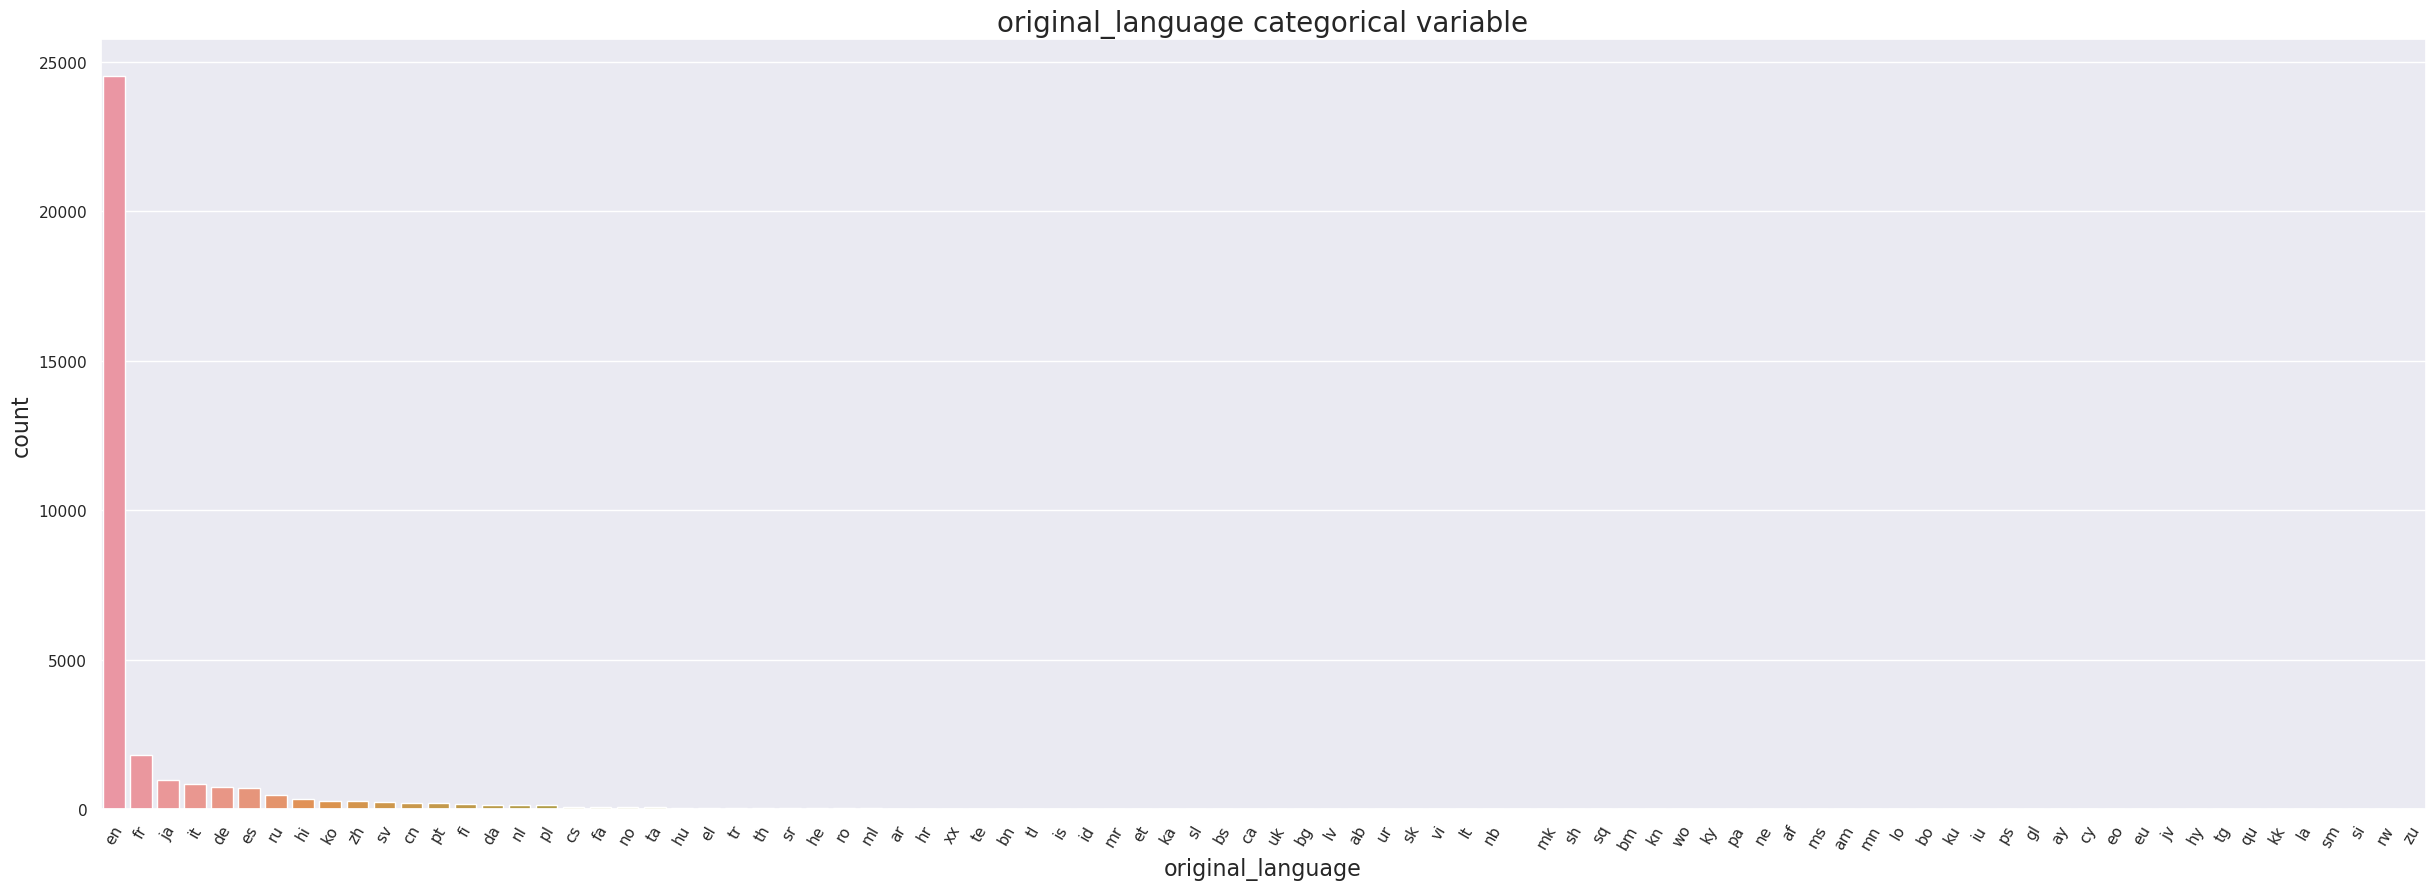

In [29]:
pl.xxl_flat_size()
pl.describe_cat_var(movies3, 'original_language')

**Observaciones**

* Es de esperar que el lenguage predominante sea el ingles.

!uitemos esta opcion y volvamos a graficas:

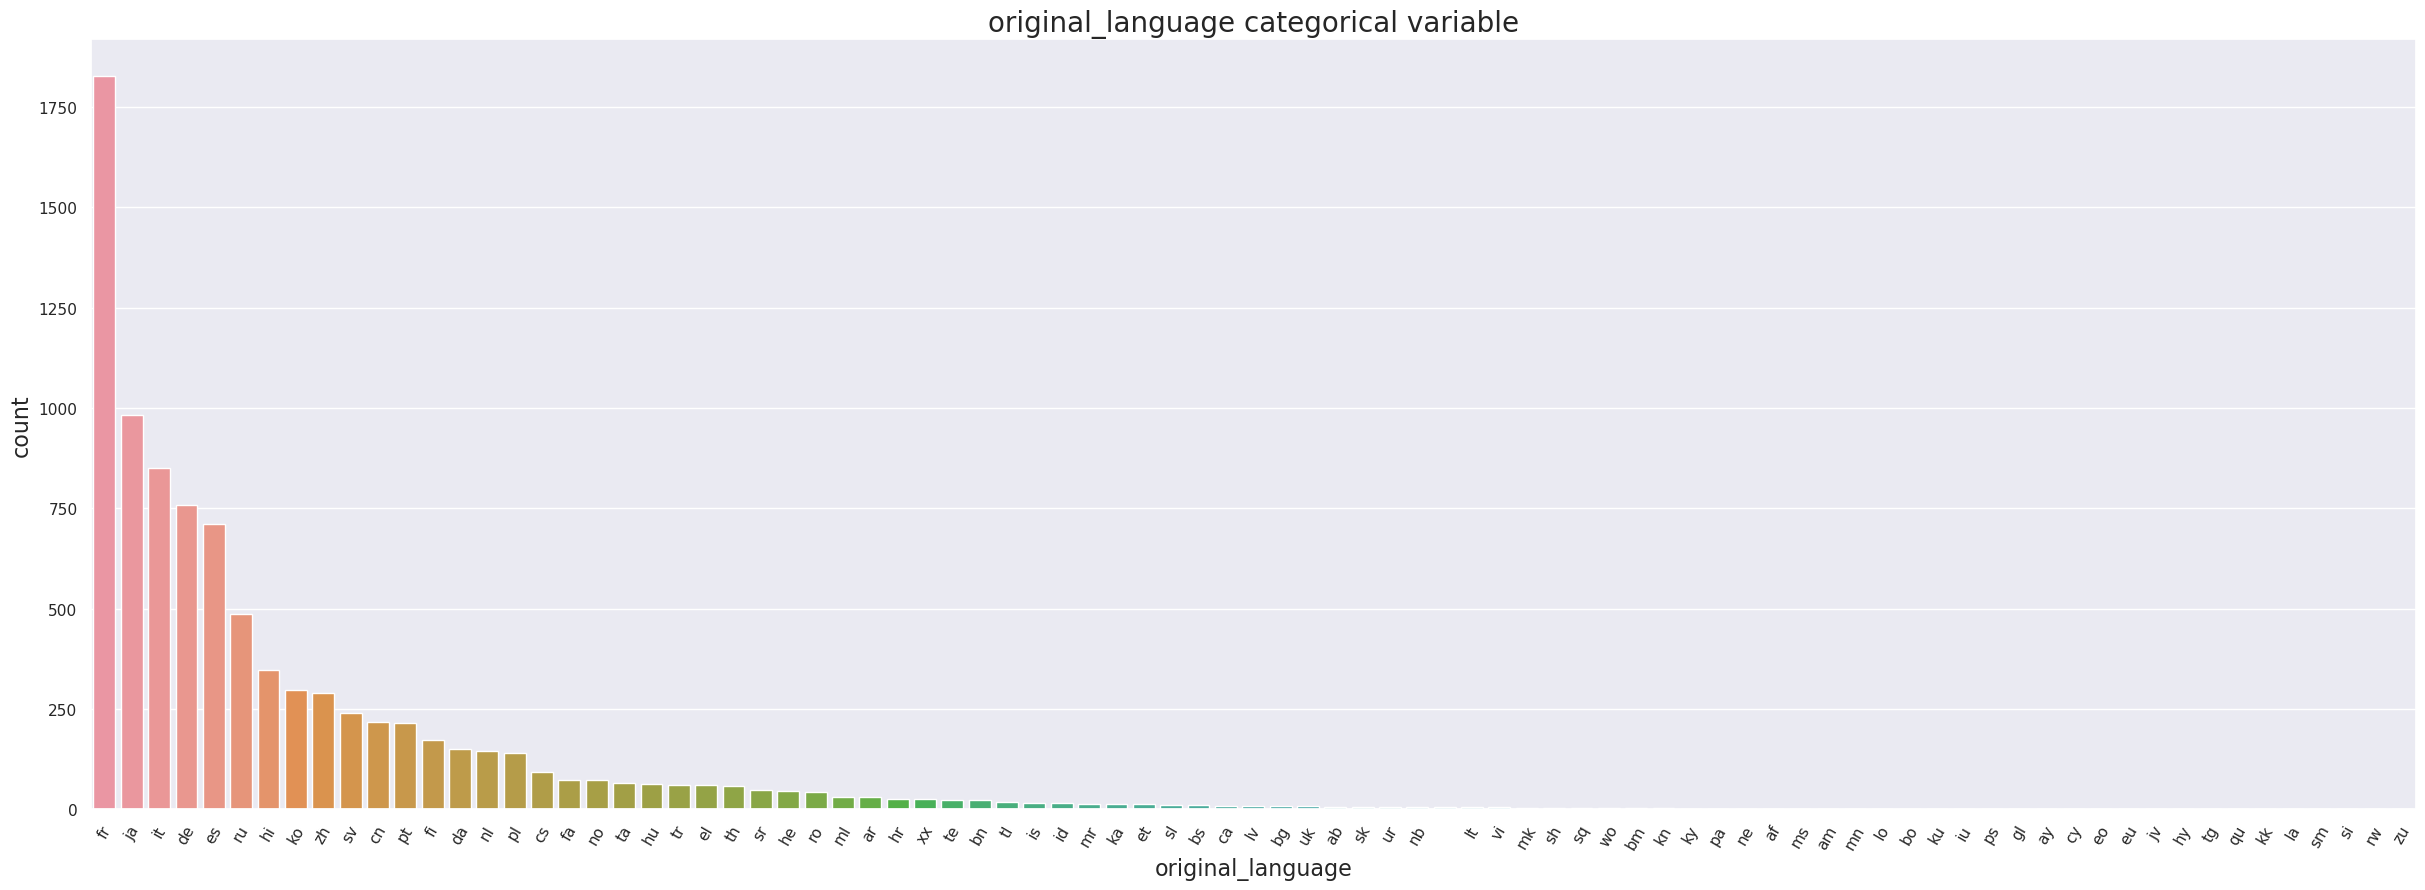

In [30]:
pl.xxl_flat_size()
pl.describe_cat_var(
    movies3[movies3['original_language'] != 'en'], 
    'original_language'
)

**Observaciones**

* Vemos que que los lenguajes frances, japones, italiana, aleman y español son los lenguages originales con mas mayor ferciencia. Eston indica indirectamente que son los paises con mas peso en el mundo sinematografico ademas de los paises de habla inglesa.

### Cantidad de votos

Representa la cantidad de votos o calificaciones que recibio la pelicula en el dataset en the movie database.

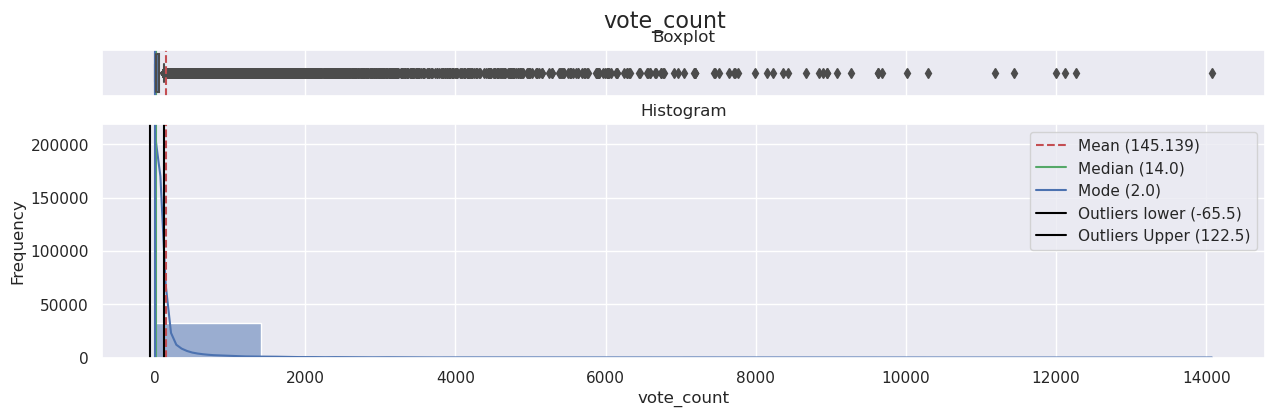

In [31]:
pl.l_flat_size()
pl.describe_num_var(movies3, "vote_count", bins=10)

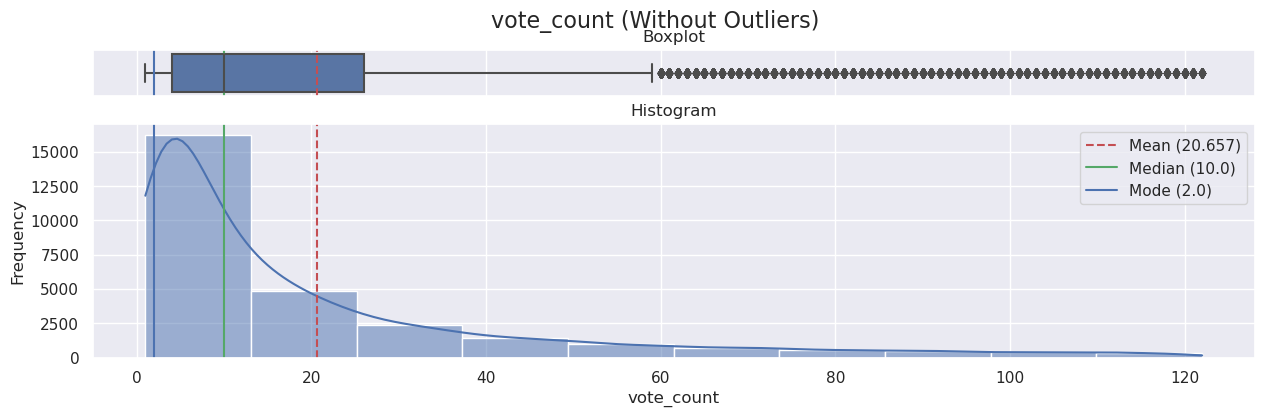

In [32]:
pl.describe_num_var(movies3, "vote_count", bins=10, remove_outliers=True)

### Tags

Esta columna tiene un conjunto sin repeticion de los tagas agragrados por todos los auaurios que calificaron una pelicula. Cada tag es una palabra o conunto de palabras. A continuacion se grafica una nube de palabras para visualiazr la freciencia relativa de las palabras que comonen los tagas:

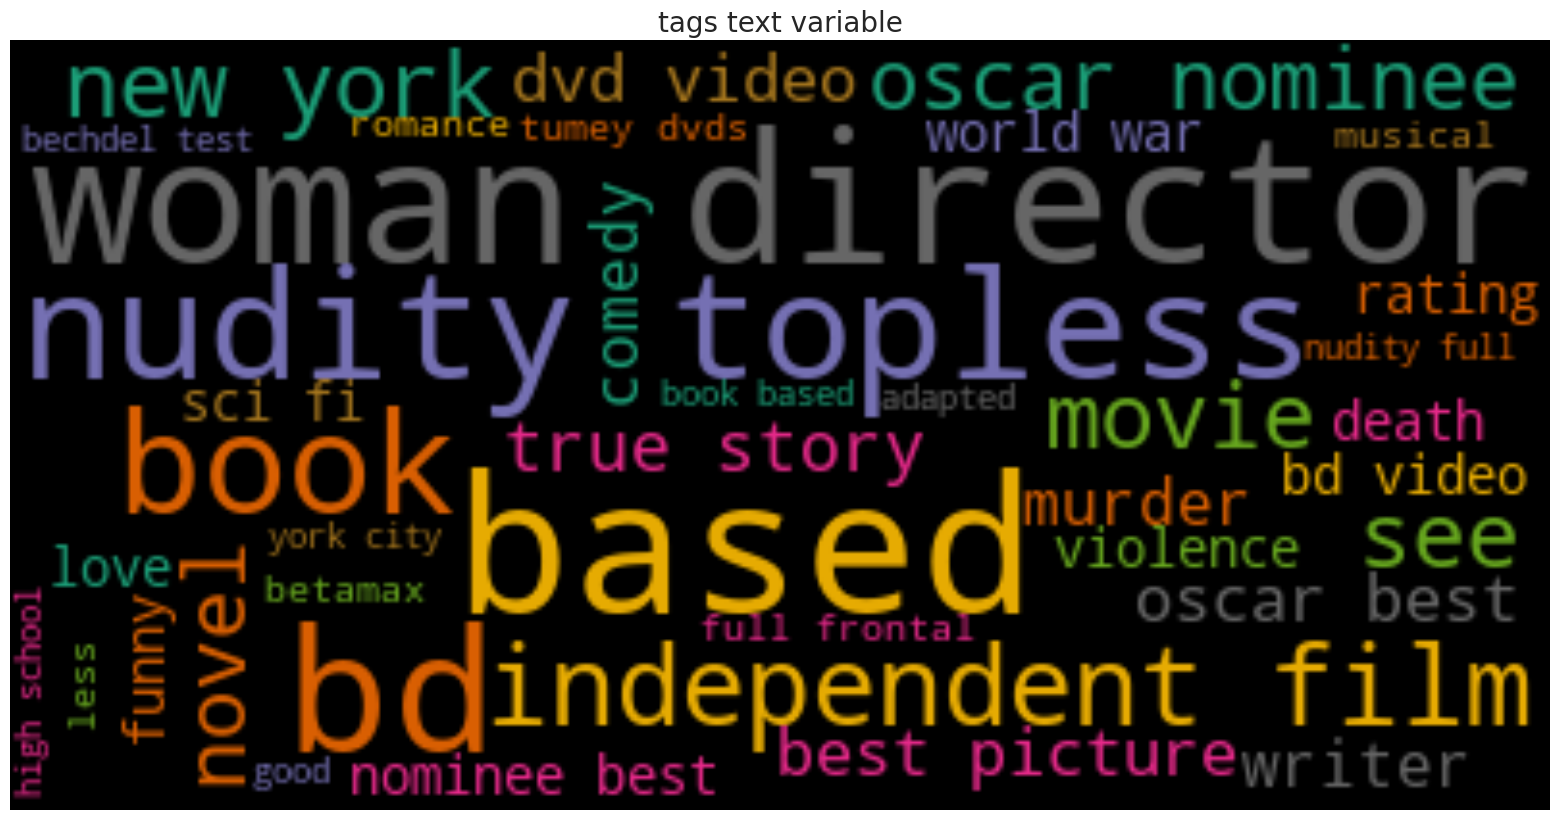

In [33]:
pl.xxl_flat_size()
pl.describe_text_var(movies3, 'tags', flatten=True)

### Overview

La variable overview contiene la reseña o un resumen de la pelicula. Al igual qeu la variable tagas graficamos una nube de palabras para visualizar la freciencia relativa de las mismas:

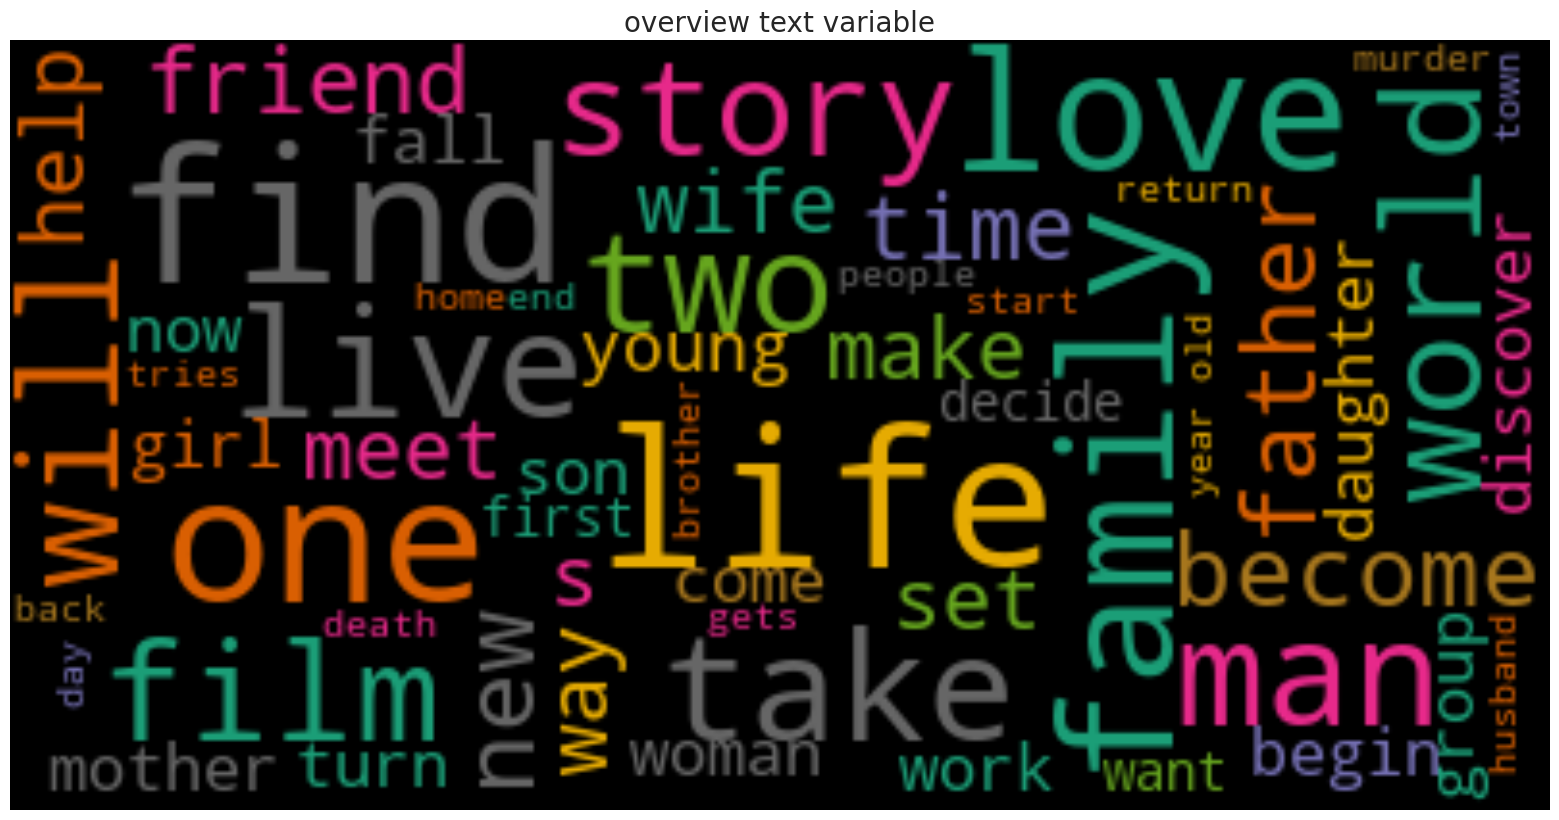

In [34]:
pl.xxl_flat_size()
pl.describe_text_var(movies3, 'overview')

## Title

Esta varaible reprsenta el titulo de una pelicula. A continuacion nuevamente graficamos la frecuenia relativa de las palabar que componen todos los titulos del dataset:

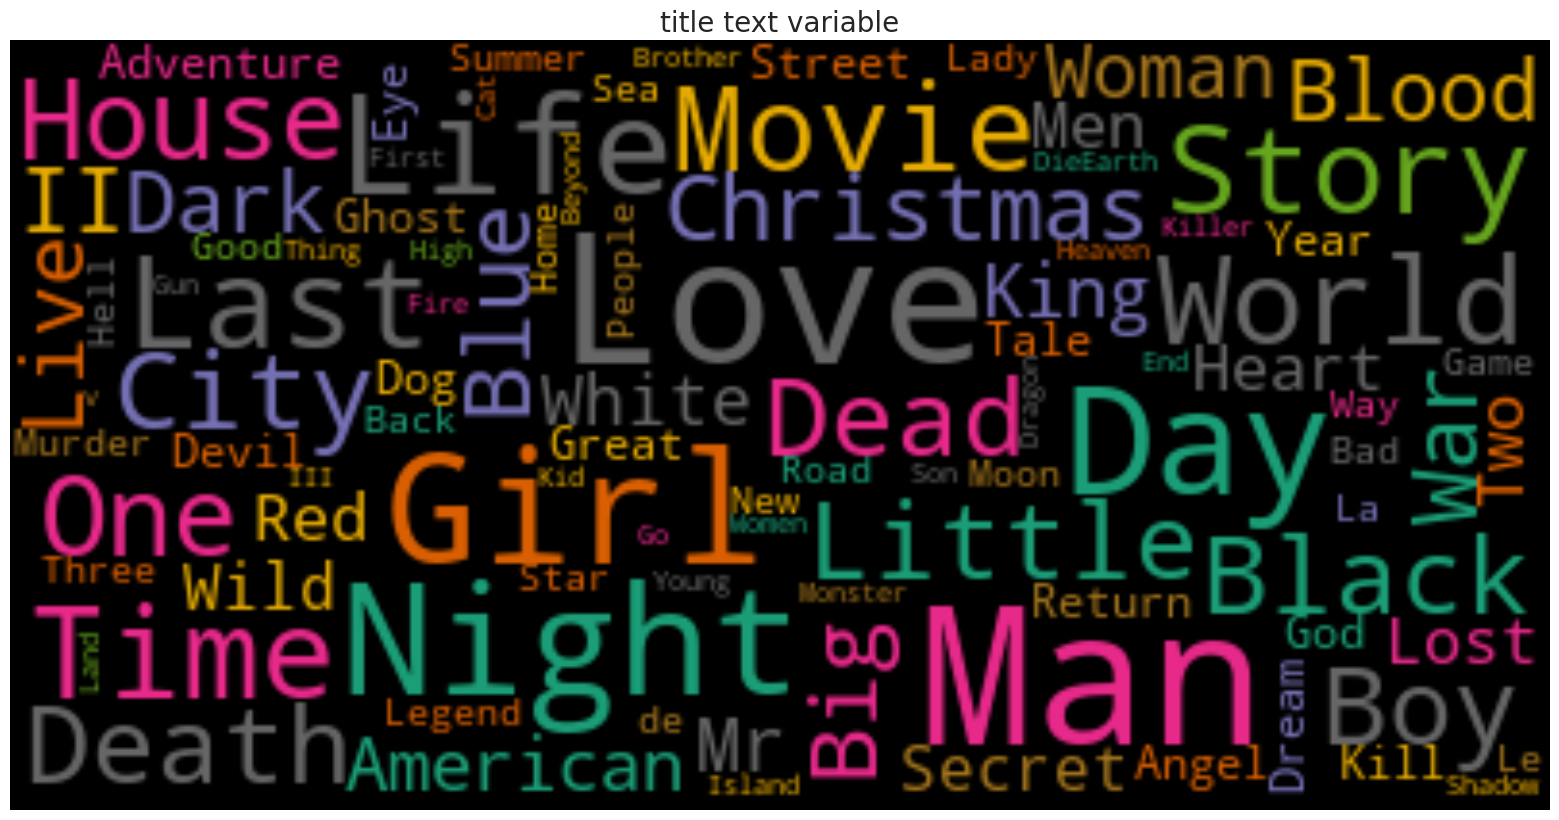

In [35]:
pl.xxl_flat_size()
pl.describe_text_var(movies3, 'title')

## Interactions

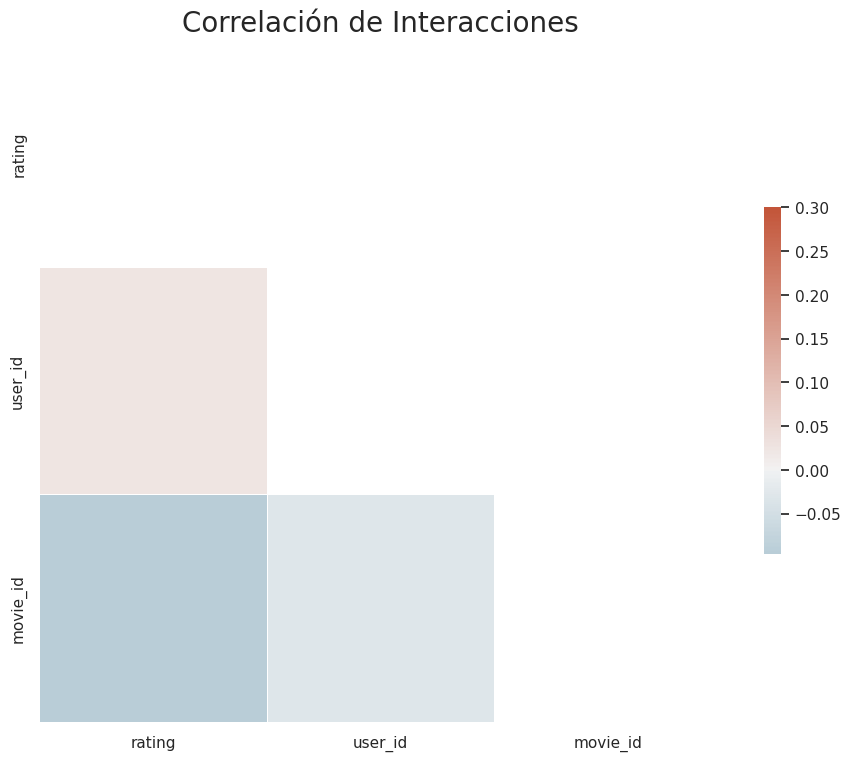

In [36]:
pl.correlations(
    interactions, 
    title='Correlación de Interacciones'
)

### Rating

In [37]:
dt.group_by(interactions, 'rating')

rating 
 count 
 
 
 
 
 7 
 4.0 
 49438 
 
 
 9 
 5.0 
 37157 
 
 
 6 
 3.5 
 34047 
 
 
 8 
 4.5 
 32330 
 
 
 5 
 3.0 
 25186 
 
 
 4 
 2.5 
 11889 
 
 
 3 
 2.0 
 8924 
 
 
 2 
 1.5 
 4225 
 
 
 1 
 1.0 
 3923 
 
 
 0 
 0.5 
 3606

Veamos la distribución de la calificaciones de la peliculas realizadas por los usaurio para todo el periodo del dataset:

In [38]:
years_range = (interactions['timestamp'].min().strftime("%Y-%m"), interactions['timestamp'].max().strftime("%Y-%m"))
years_range

('1997-09', '2019-11')

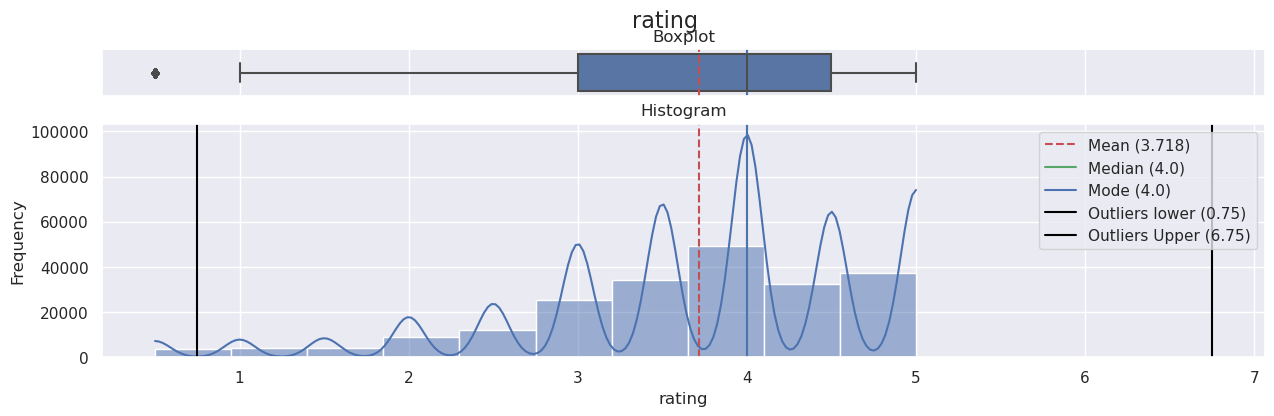

In [39]:
pl.l_flat_size()
pl.describe_num_var(interactions, "rating", bins=10)

Ahora veamos como cambia la distribucion del rating a través de los años:

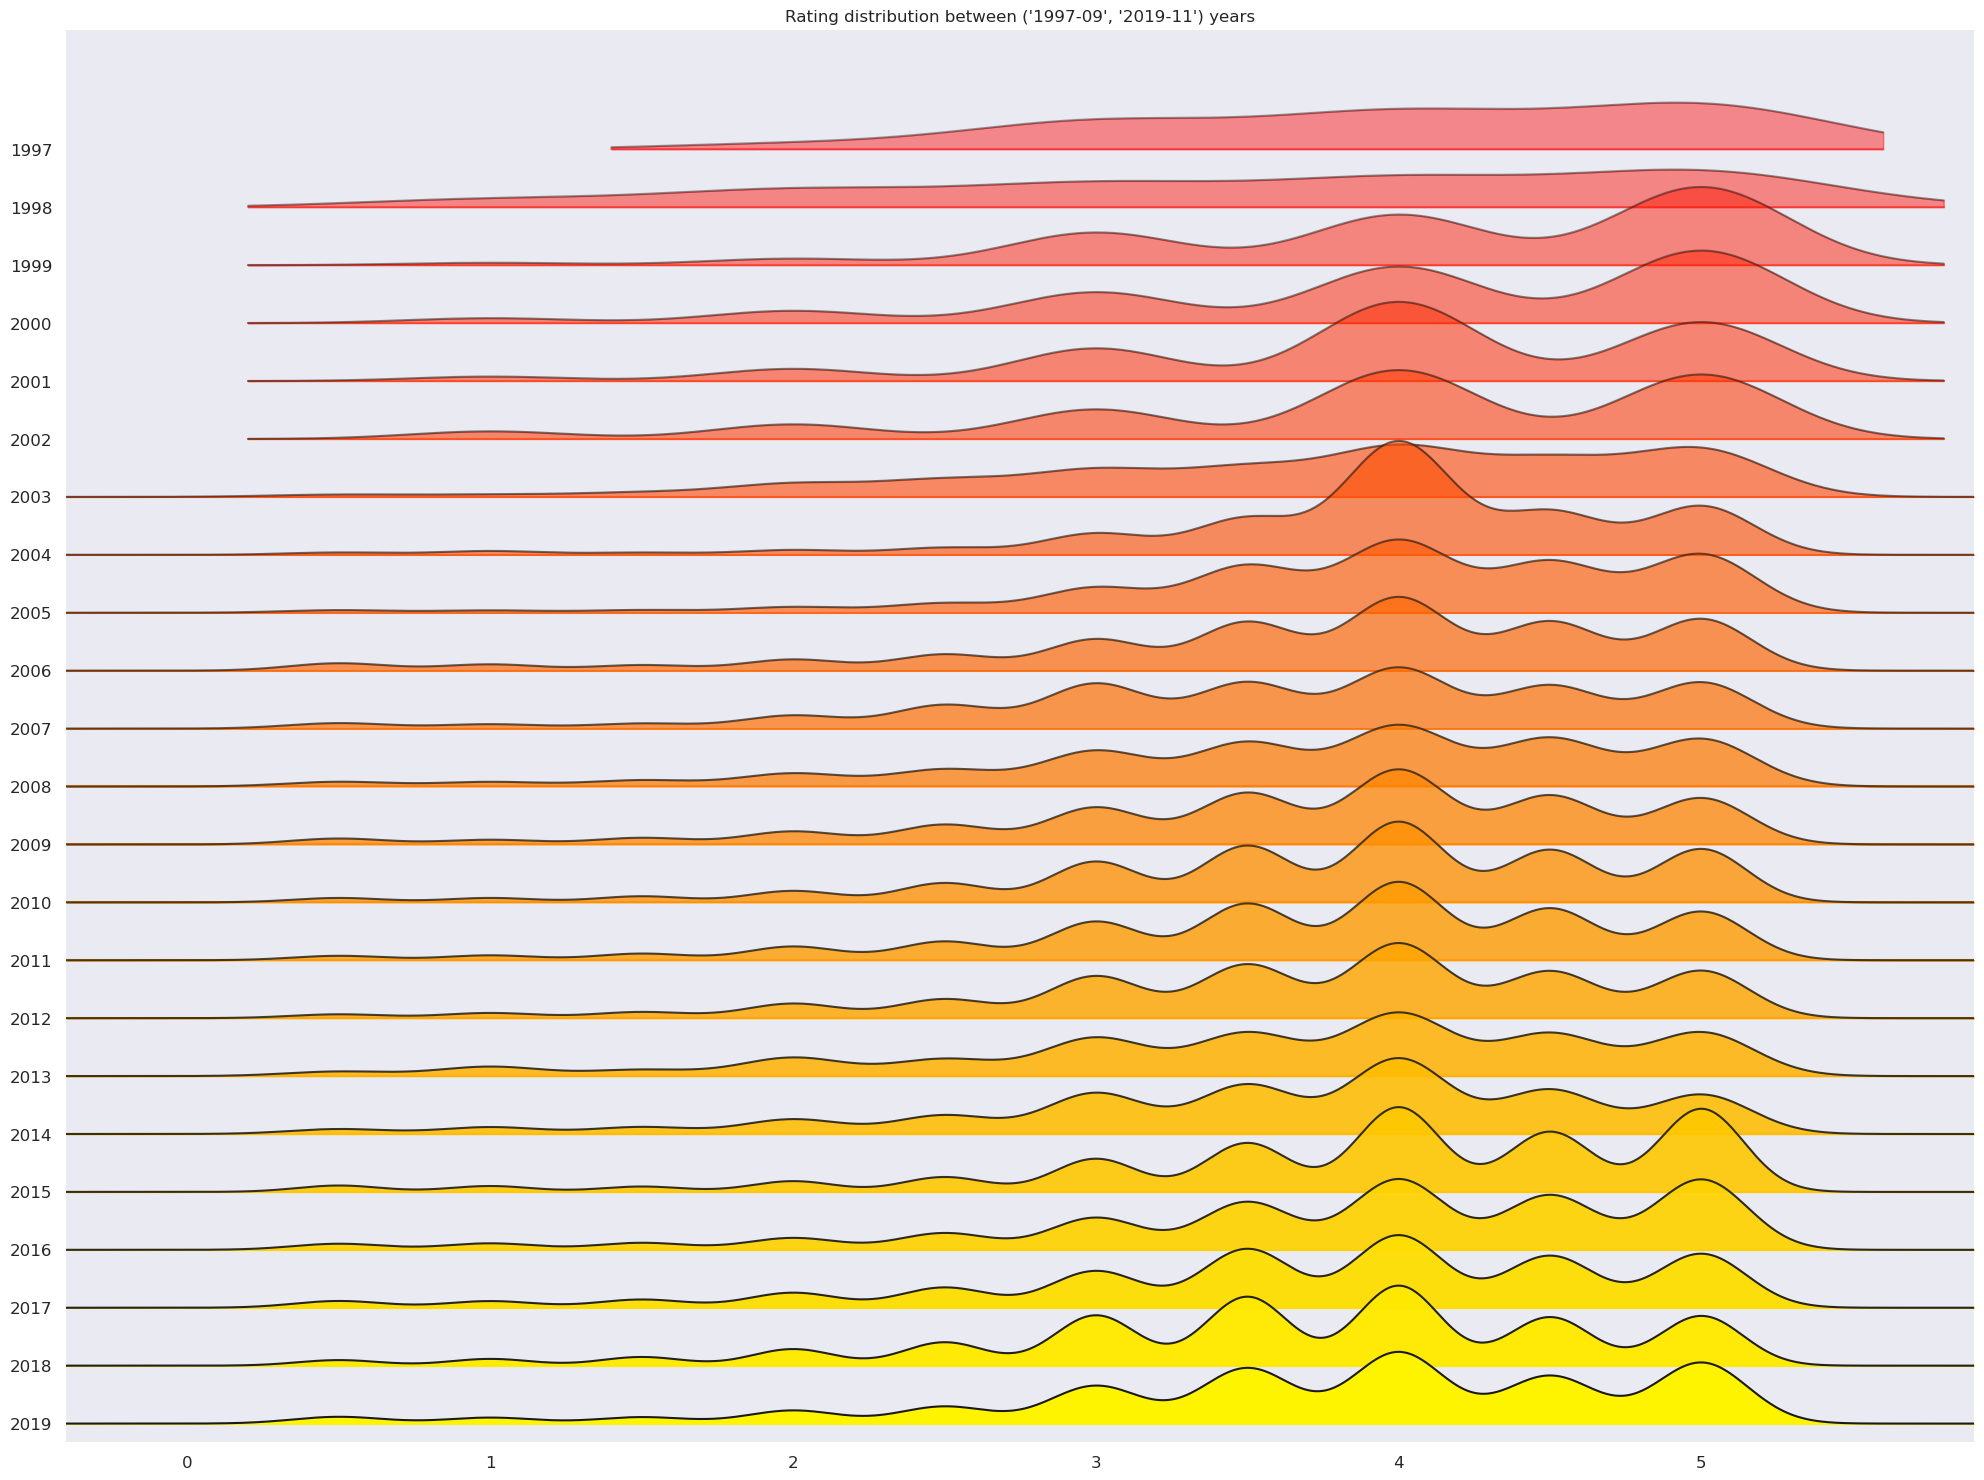

In [40]:
interactions['year'] = interactions.timestamp.dt.year

pl.xl_size()
pl.ridgeplot(interactions, by='year', column='rating', title=f'Rating distribution between {years_range} years')

# Peliculas y interacciones

# Correlaciones

In [42]:
complete_data = pd.merge(
        movies3,
        interactions,
        how='inner',
        left_on=['id'],
        right_on=['movie_id']
    )
complete_data = complete_data.loc[:, complete_data.columns!='id']
complete_data = complete_data.loc[:, complete_data.columns!='year']


complete_num_data = complete_data \
    .select_dtypes(include=np.number)

norm_complete_num_data = ut.norm(complete_num_data).drop(columns=['imdb_id'])

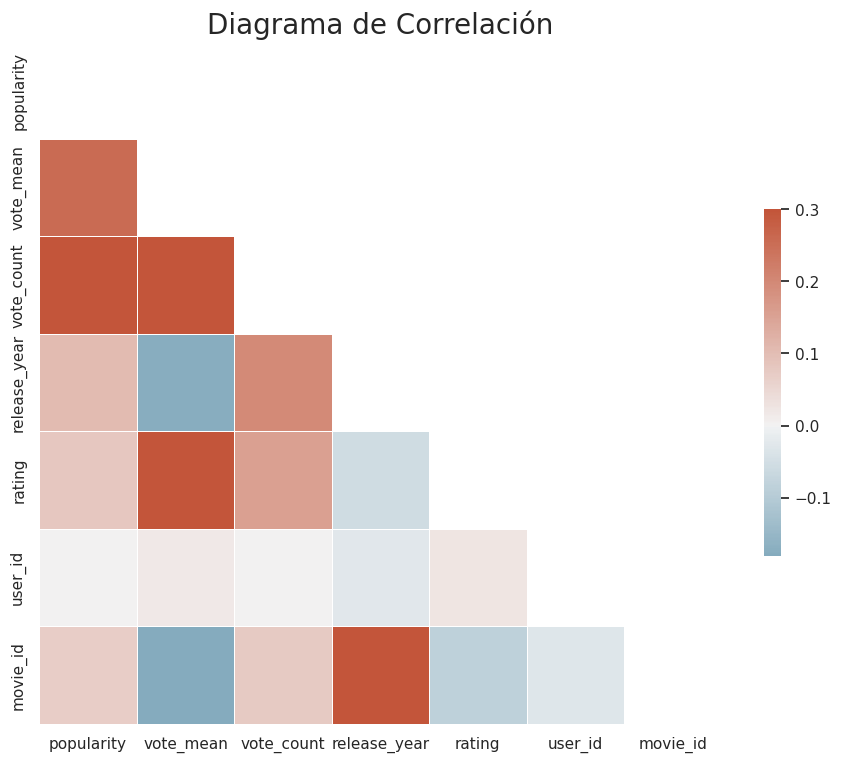

In [43]:
pl.correlations(norm_complete_num_data)

/home/adrian/.conda/envs/thesis/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/adrian/.conda/envs/thesis/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/adrian/.conda/envs/thesis/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/adrian/.conda/envs/thesis/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/adrian/.conda/envs/thesis/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorb

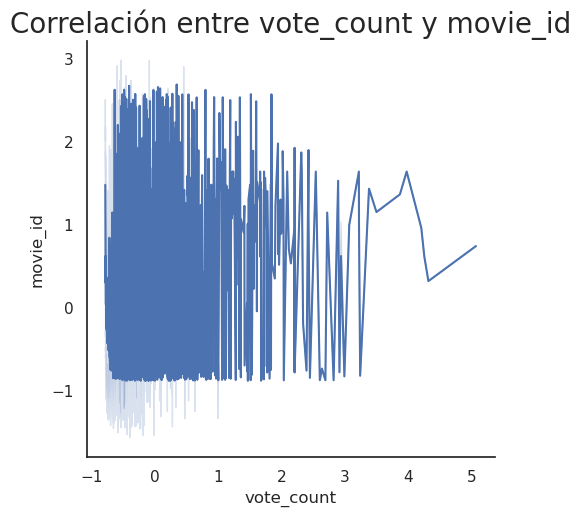

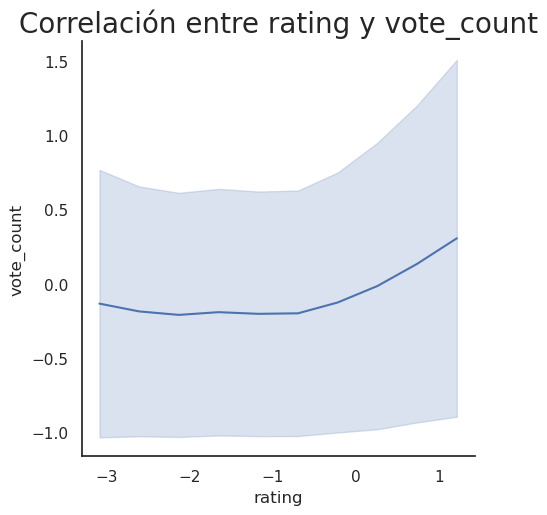

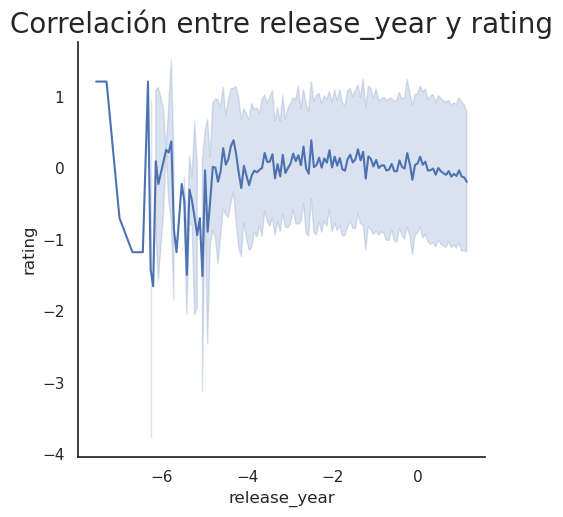

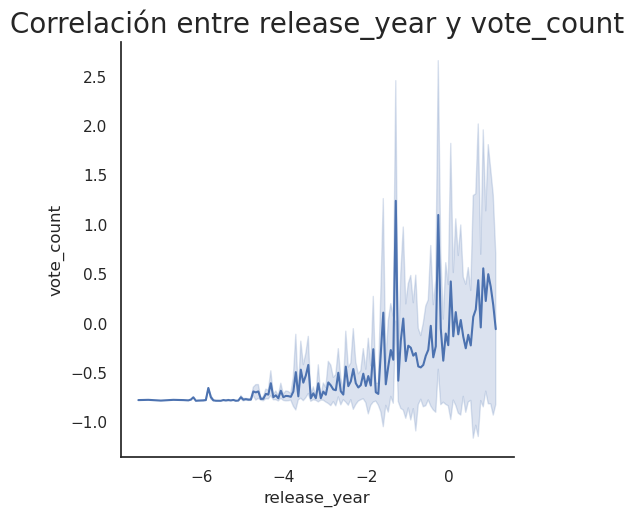

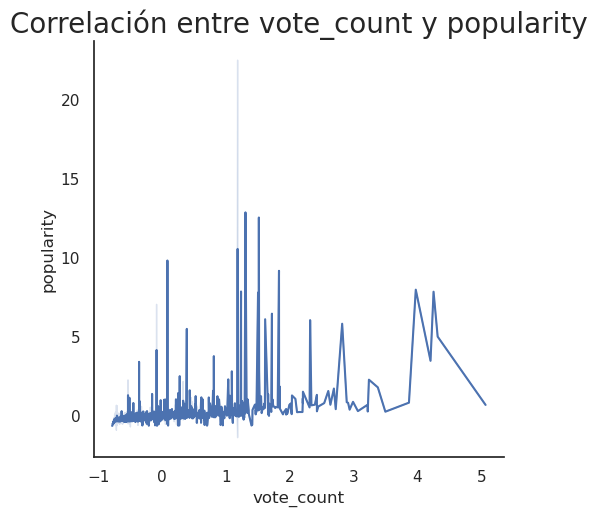

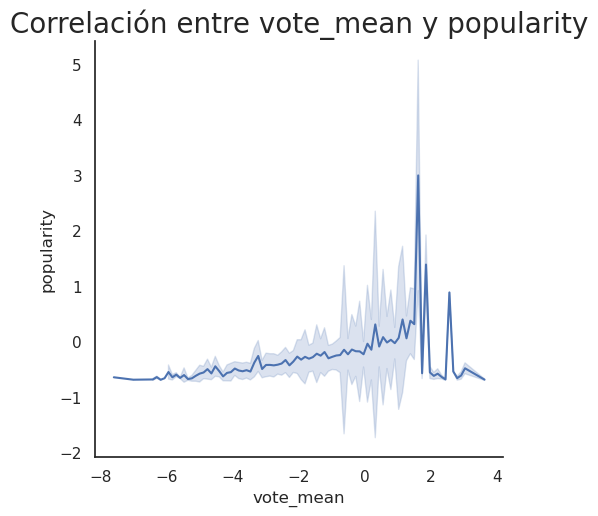

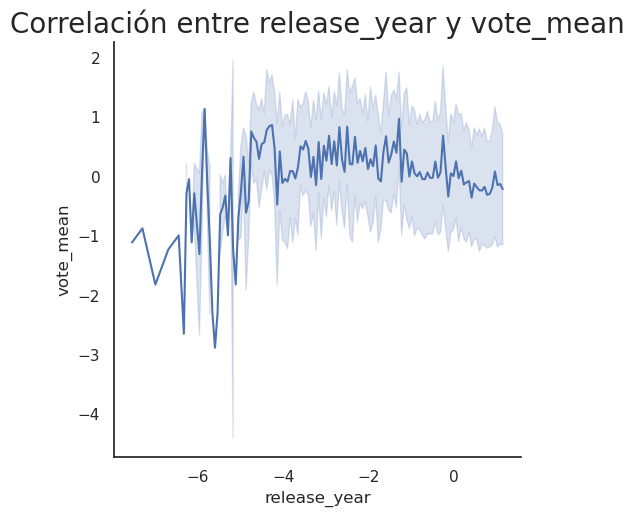

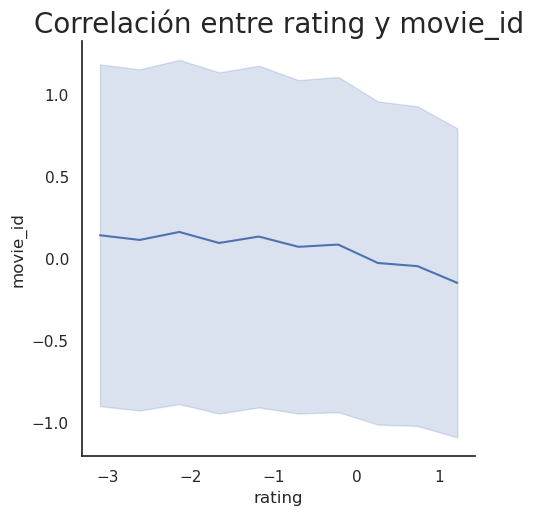

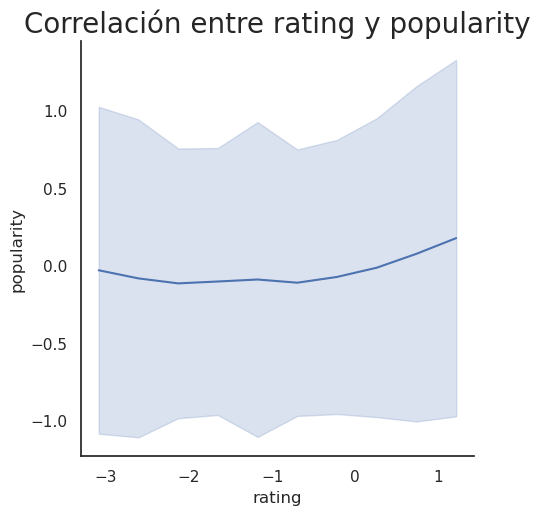

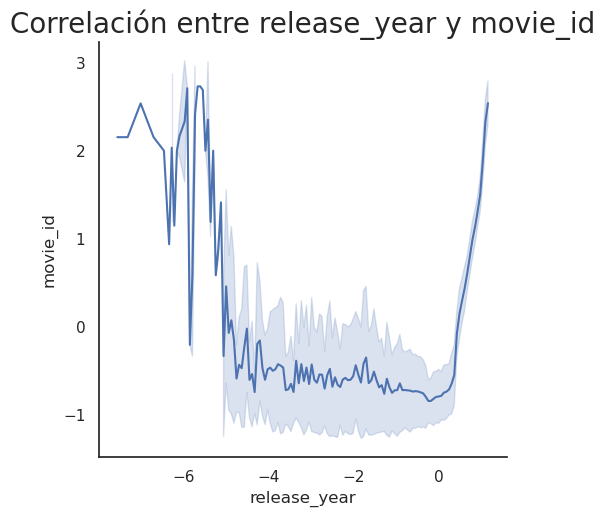

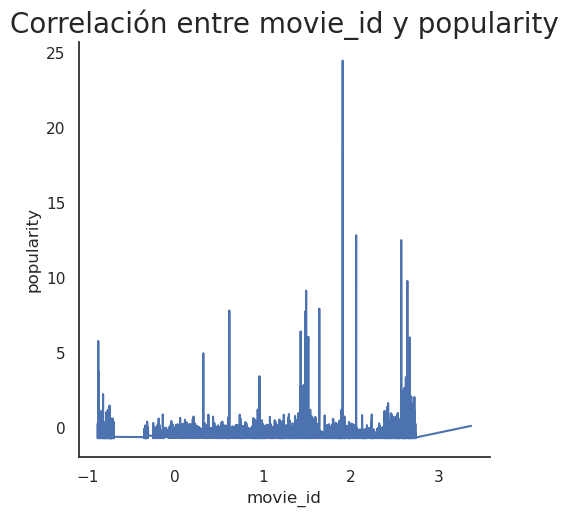

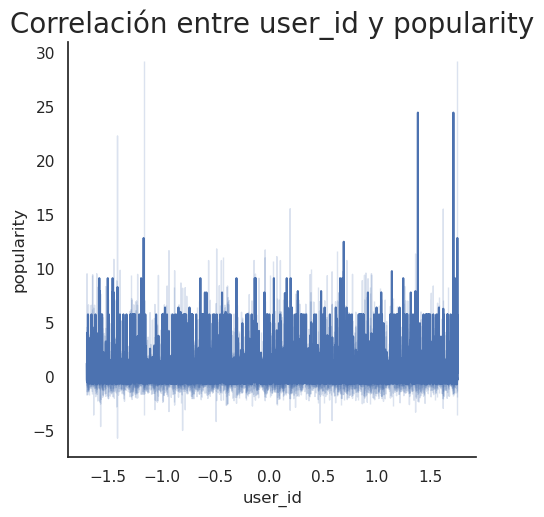

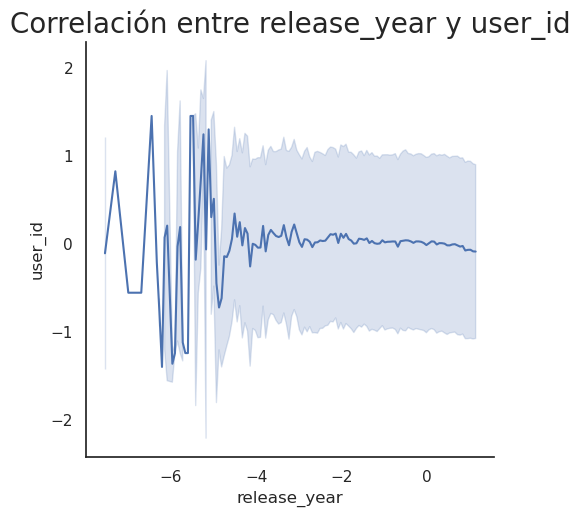

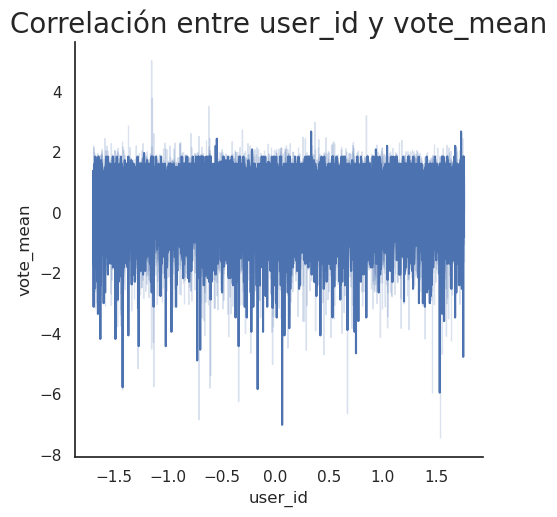

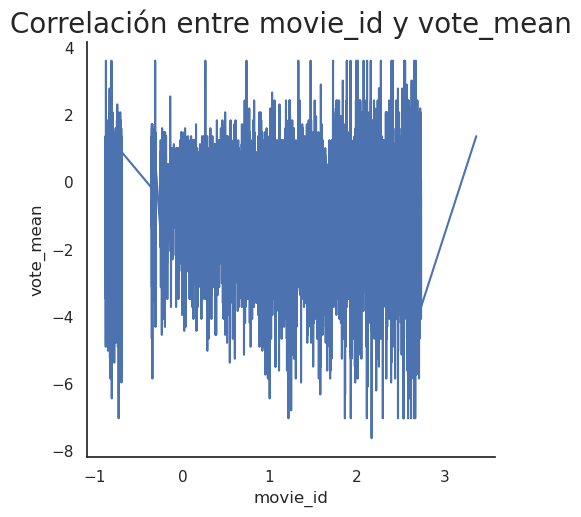

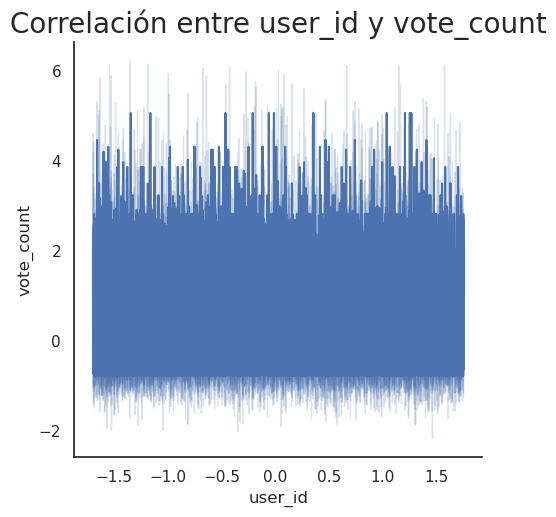

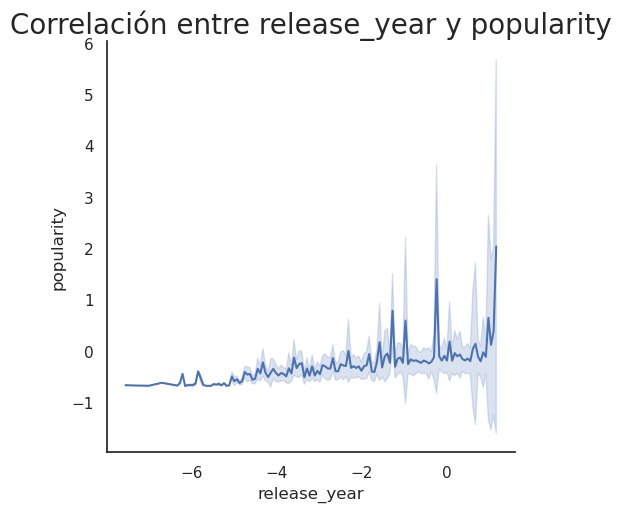

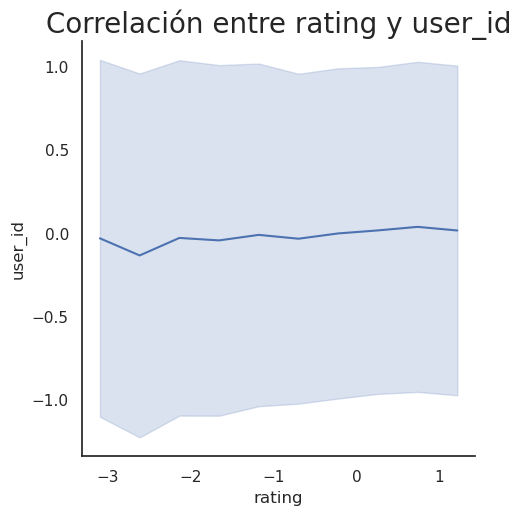

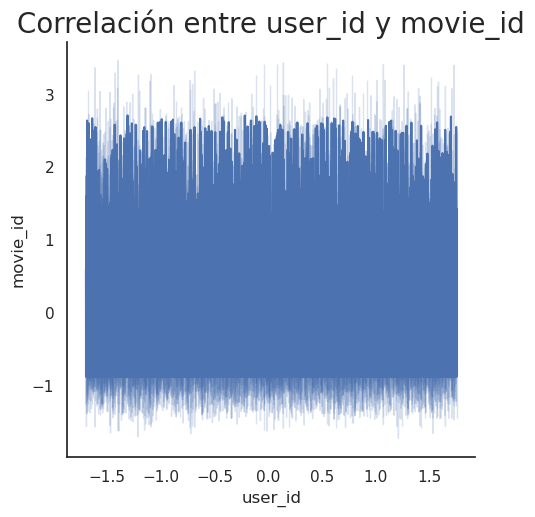

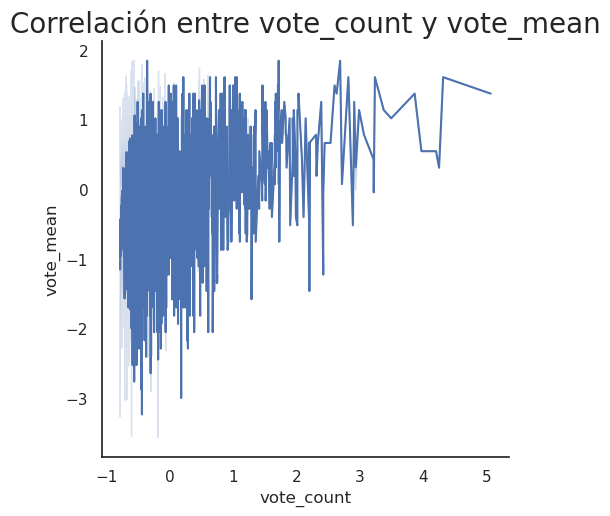

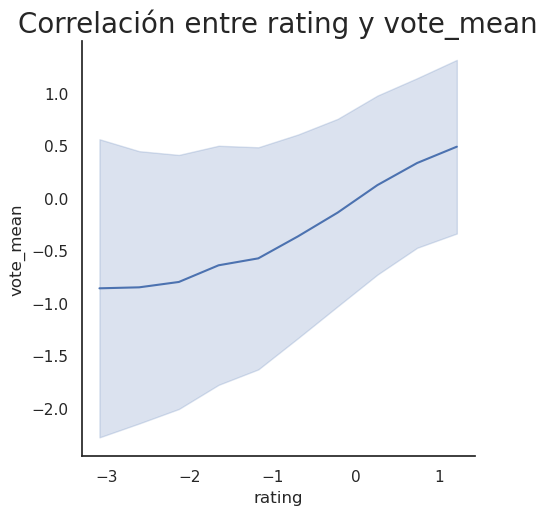

In [44]:
pl.plot_correlations(norm_complete_num_data)

# Componentes Principales

In [45]:
clusters = {
    0.5: '<2',
    1.0: '<2',
    1.5: '<2',

    2.0: '2-3.5',
    2.5: '2-3.5',
    3.0: '2-3.5',
    3.5: '2-3.5',

    4.0: '>4',
    4.5: '>4',
    5.0: '>4'
}


X  = norm_complete_num_data.copy().drop(columns=['rating'])
y  = complete_num_data.rating.apply(lambda x: clusters[x])

In [46]:
X

popularity 
 vote_mean 
 vote_count 
 release_year 
 user_id 
 movie_id 
 
 
 
 
 0 
 0.089539 
 -0.041519 
 0.219785 
 -0.187050 
 -1.629151 
 -0.879894 
 
 
 1 
 0.089539 
 -0.041519 
 0.219785 
 -0.187050 
 -1.586014 
 -0.879894 
 
 
 2 
 0.089539 
 -0.041519 
 0.219785 
 -0.187050 
 -1.557270 
 -0.879894 
 
 
 3 
 0.089539 
 -0.041519 
 0.219785 
 -0.187050 
 -1.552536 
 -0.879894 
 
 
 4 
 0.089539 
 -0.041519 
 0.219785 
 -0.187050 
 -1.551411 
 -0.879894 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 199786 
 -0.688543 
 0.076730 
 -0.782399 
 0.117083 
 -1.239283 
 2.734057 
 
 
 199787 
 -0.661650 
 -4.061987 
 -0.782814 
 -0.187050 
 -1.239283 
 2.734180 
 
 
 199788 
 -0.674286 
 0.076730 
 -0.782814 
 0.117083 
 -1.239283 
 2.734098 
 
 
 199789 
 -0.650559 
 -3.707240 
 -0.780736 
 0.299562 
 0.304268 
 2.734385 
 
 
 199790 
 0.128167 
 1.377469 
 -0.745819 
 -0.916967 
 1.455254 
 3.367387 
 
 
 
 199791 rows × 6 columns

In [47]:
y.value_counts()

>4       114024
2-3.5     74732
<2        11035
Name: rating, dtype: int64

In [48]:
summary = dt.PCAAnalisys.make_on(X, y, n_components = 3)

In [49]:
summary.observations(indexes=[1,2])[:,0]

array([-0.01688412, -0.01708161, -0.01721321, ..., -0.34611699,
       -1.81310069,  0.50978155])

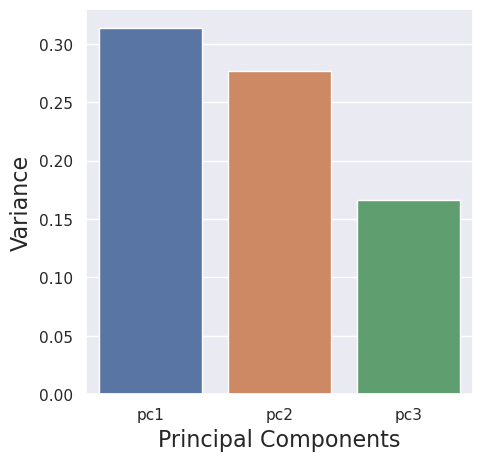

array([0.31391485, 0.27702888, 0.16615662])

In [50]:
pl.s_size()
summary.plot_explained_variance()
summary.explained_variance()

2023-02-06 18:00:00,527 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


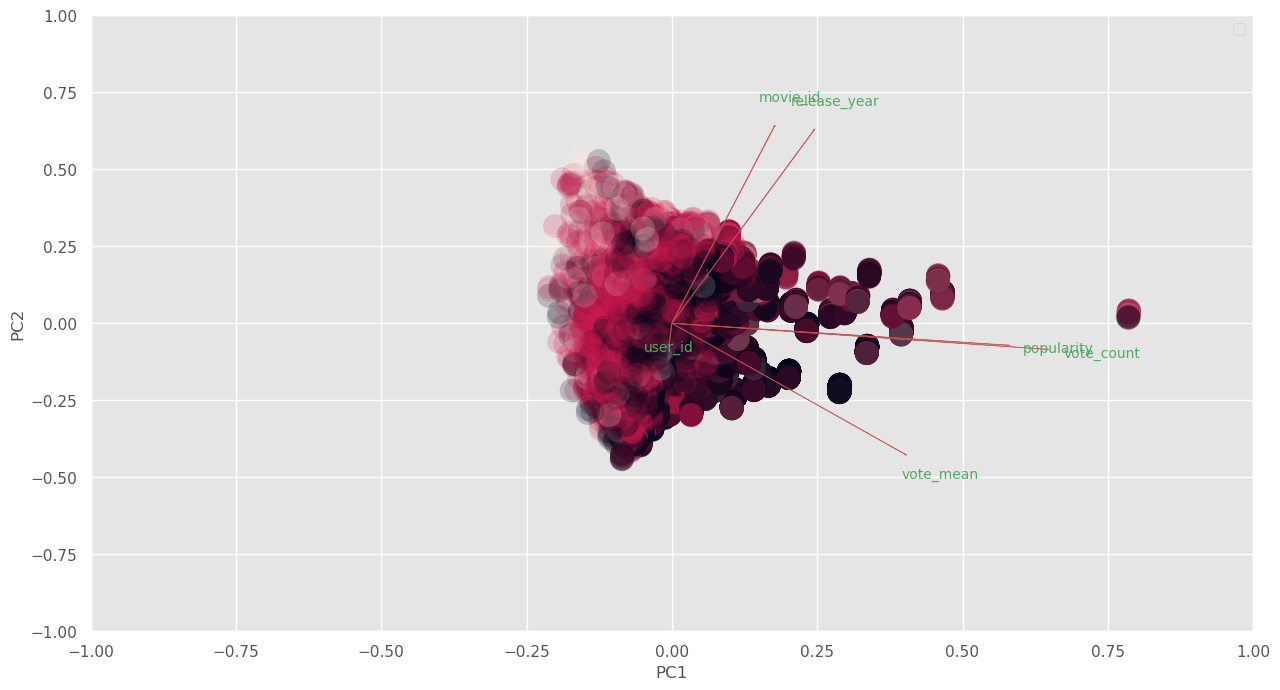

In [51]:
pl.l_size()
summary.biplot()

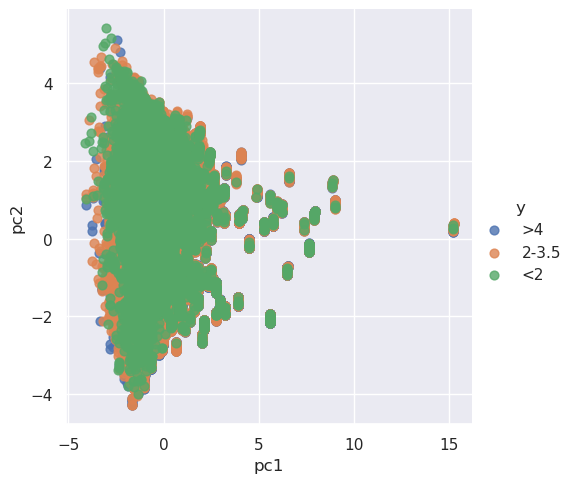

In [52]:
pl.l_size()
summary.plot_clusters()

## ¿Cuales son los generos de peliculas mas comunes?

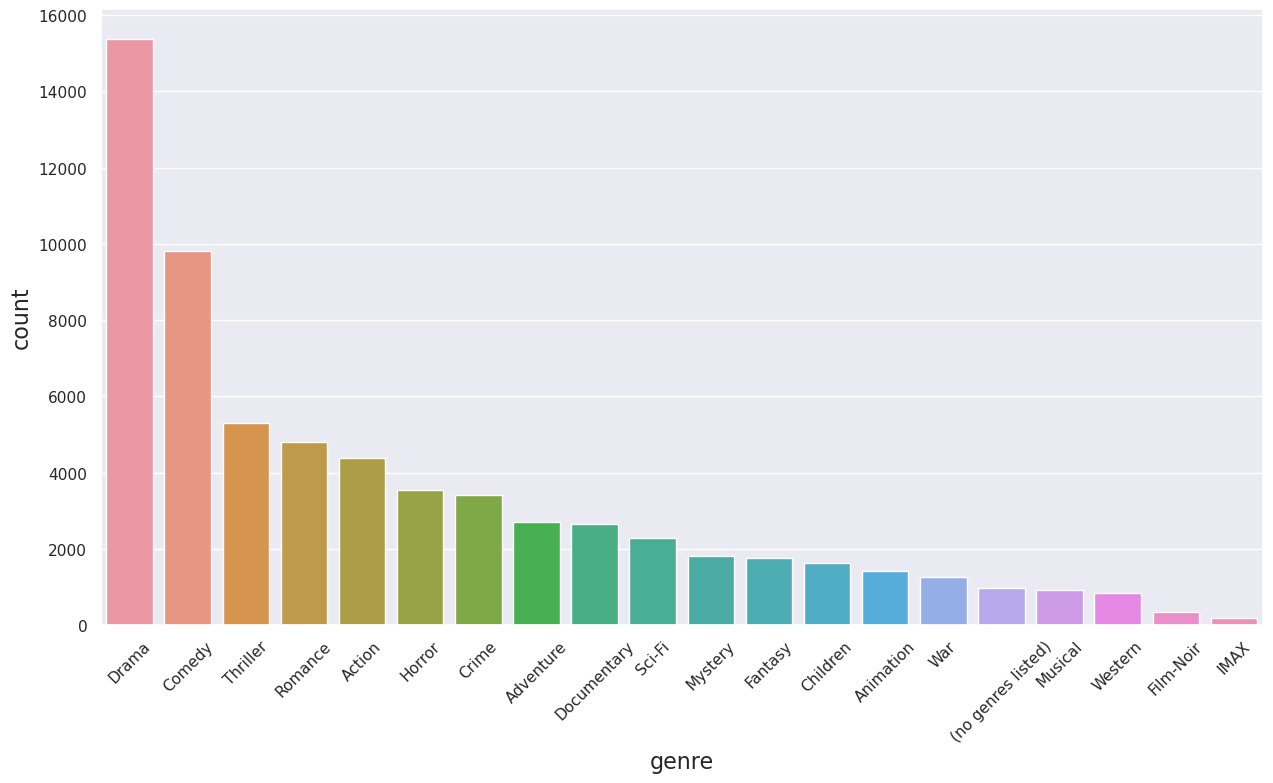

In [53]:
all_genres = lambda df: np.array([genre for genres in df['genres'].values for genre in genres])

genres_count = dt.frequency(all_genres(movies3),'genre')

pl.barplot(
    genres_count, 
    'genre', 
    'count', 
    figsize=(30, 6),
    x_rotation=45
)

## ¿Cuantas peliculas se estrenaron por año?

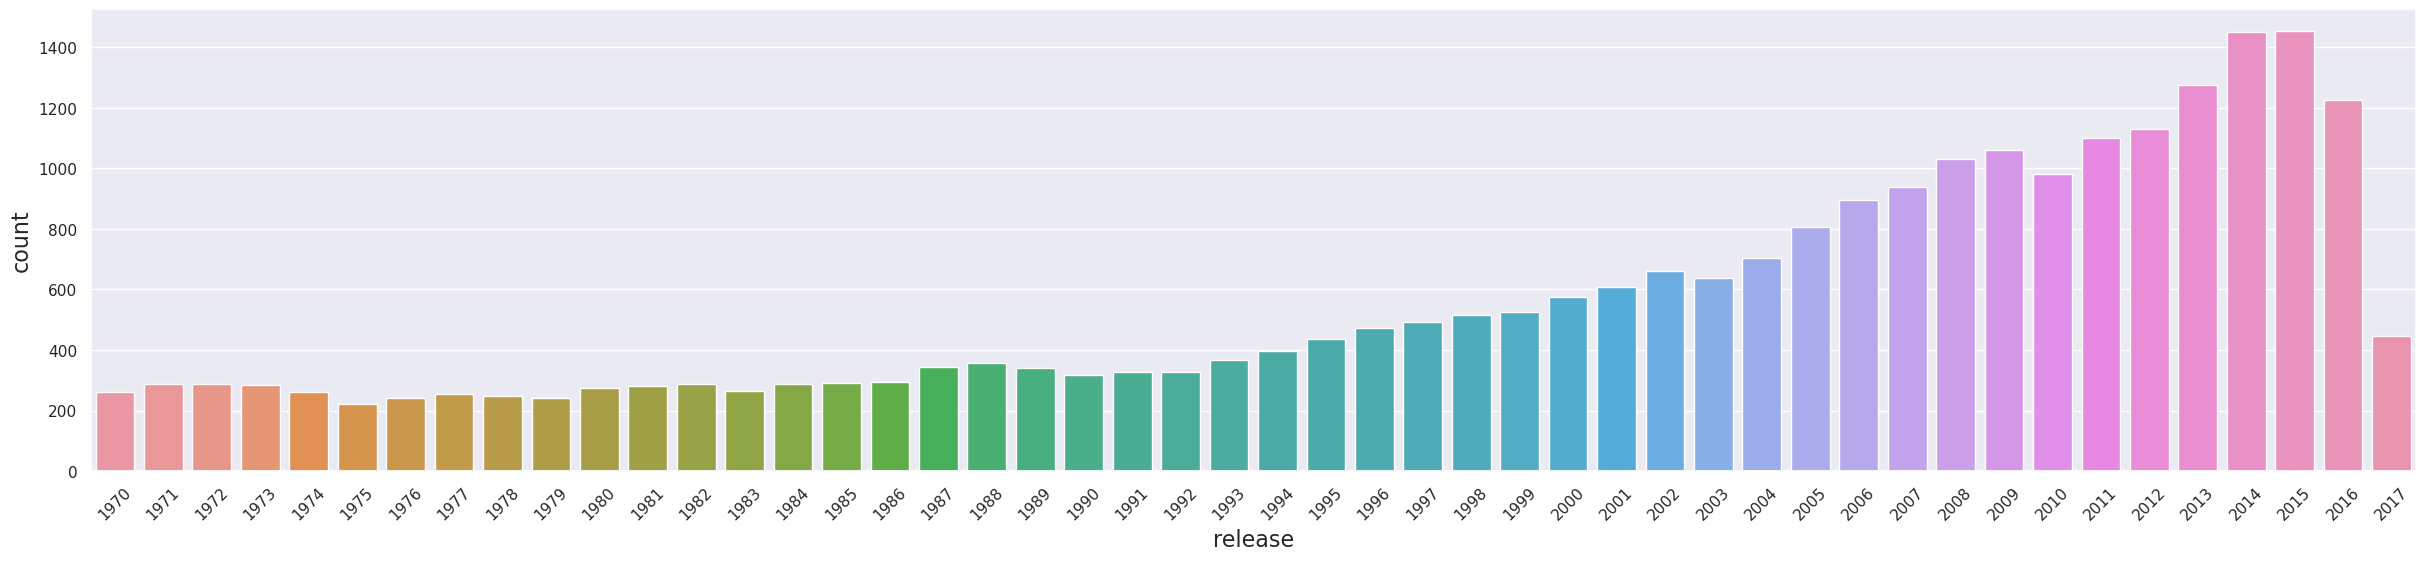

In [54]:
yearly_release_counts = movies3 \
    .groupby(movies3.release.dt.year) \
    .size() \
    .sort_values(ascending=False) \
    .reset_index(name='count')

pl.barplot(
    yearly_release_counts[yearly_release_counts.release >= 1970], 
    'release', 
    'count', 
    figsize=(30, 6), 
    x_rotation=45
)

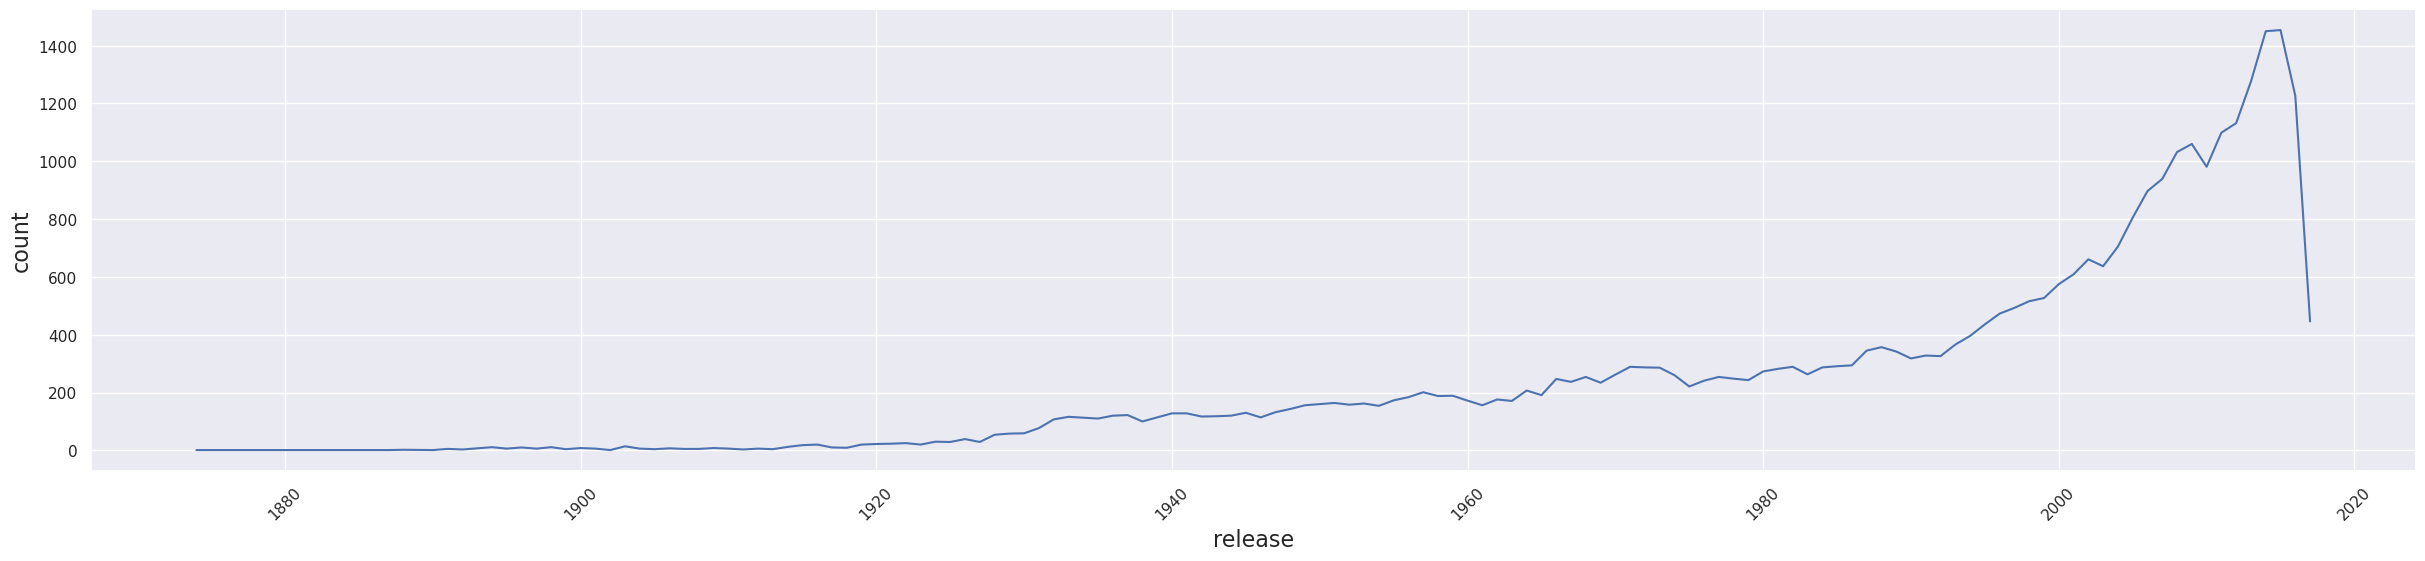

In [55]:
pl.lineplot(
    yearly_release_counts, 
    'release', 
    'count', 
    figsize=(30, 6),
    x_rotation=45
)

## ¿Cuantas peliculas se estrenaron por mes?

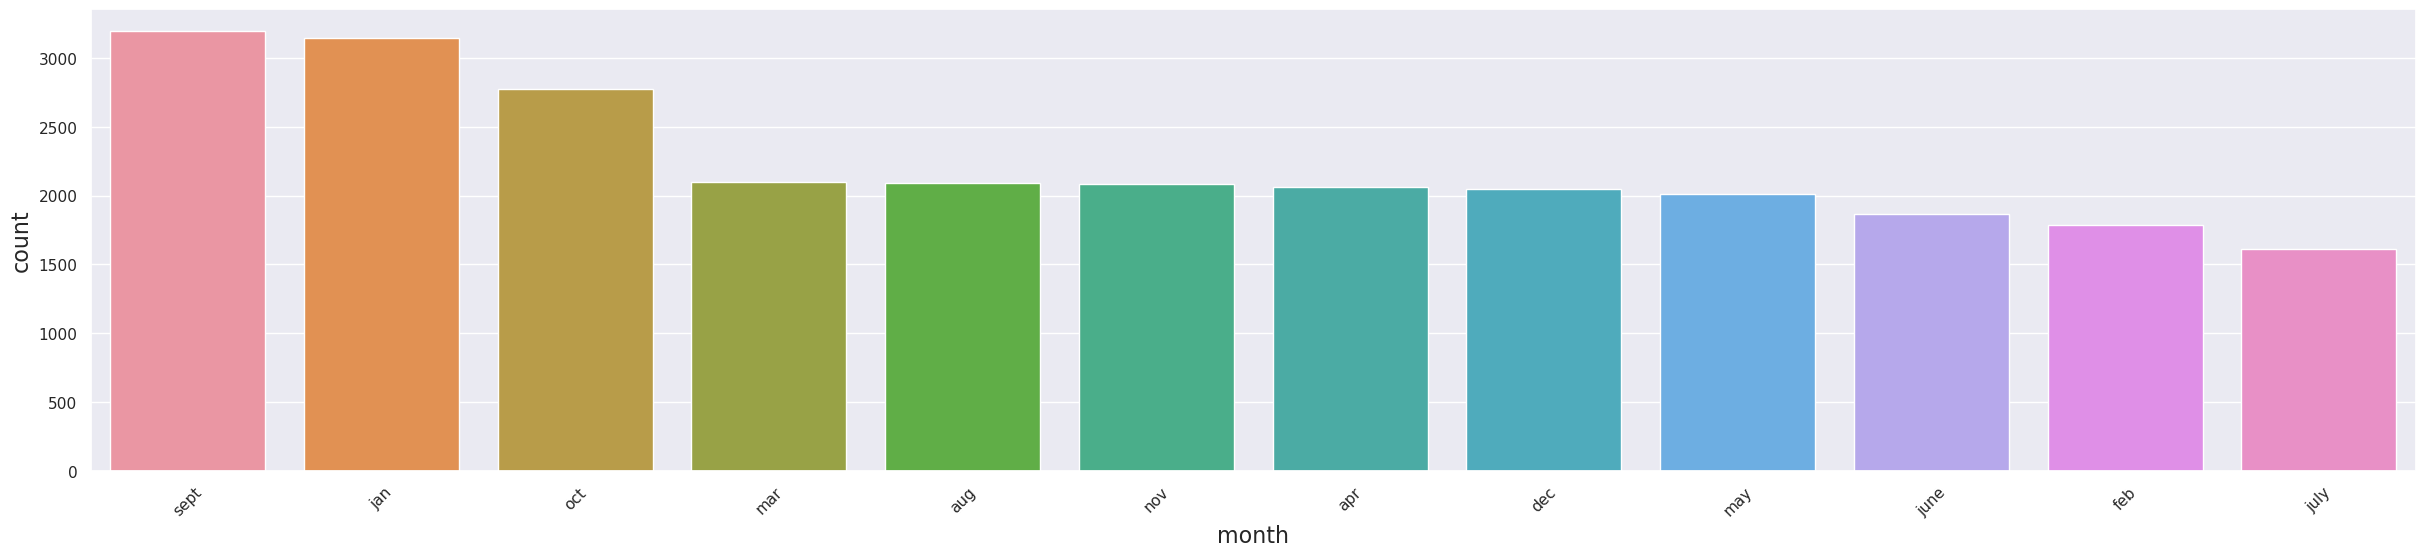

In [56]:
monthly_release_counts = movies3[movies3.release.dt.year >= 1970] \
    .groupby(movies3.release.dt.month) \
    .size() \
    .sort_values(ascending=False) \
    .reset_index(name='count')
    
monthly_release_counts['month'] = monthly_release_counts.release.apply(lambda it: dt.MONTHS[it-1])

pl.barplot(
    monthly_release_counts, 
    'month', 
    'count', 
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales son los dias de la seman preferidos para estrenar peliculas?

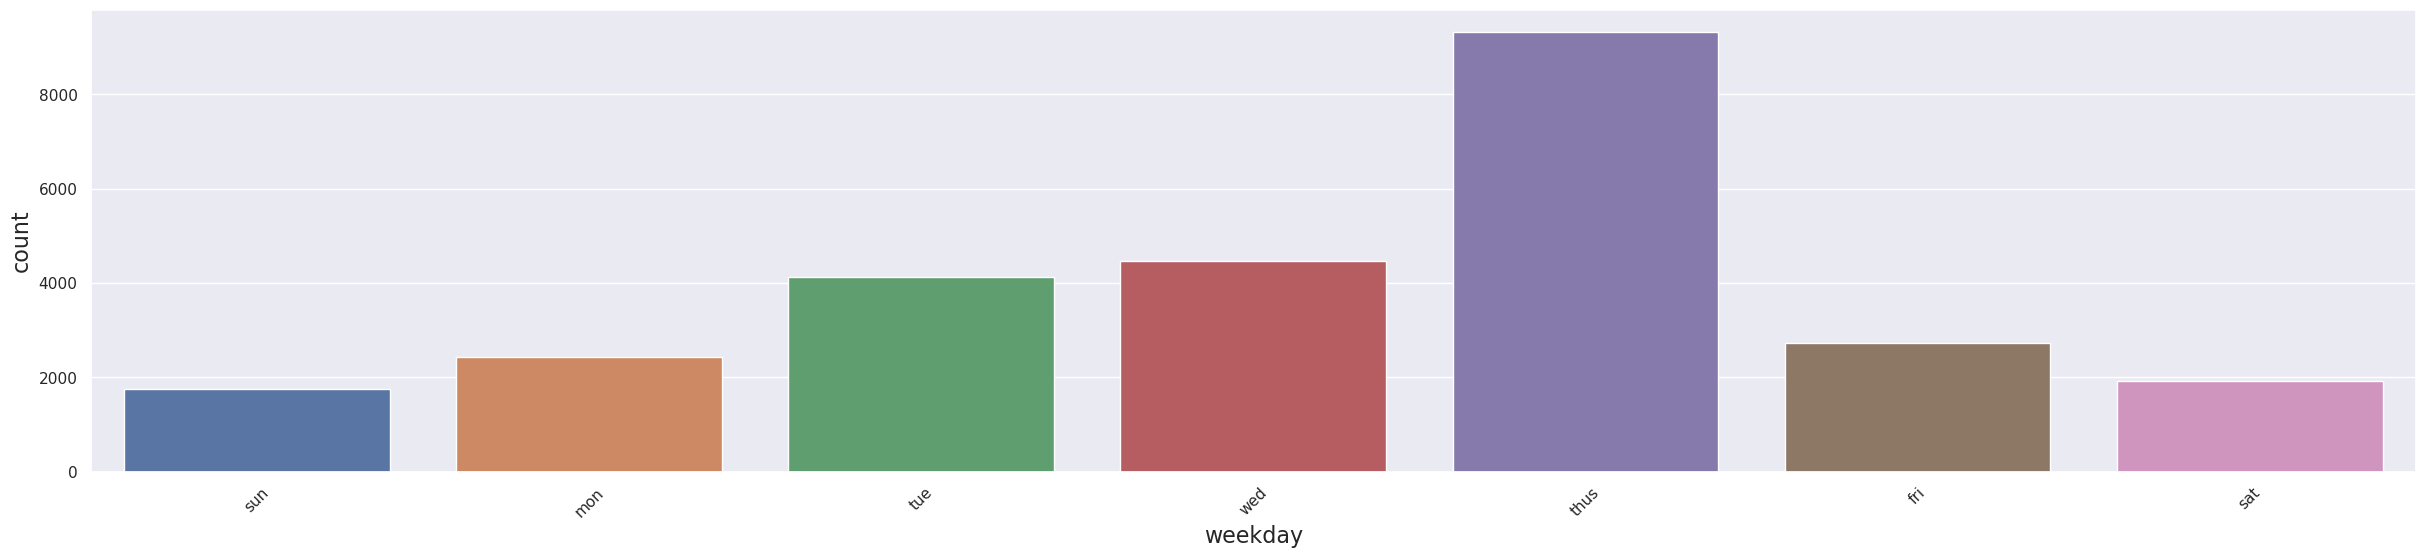

In [57]:
weekday_release_counts = movies3[movies3.release.dt.year >= 1970] \
    .groupby(movies3.release.dt.dayofweek) \
    .size() \
    .reset_index(name='count')
    
weekday_release_counts['weekday'] = weekday_release_counts \
    .release.apply(lambda it: dt.WEEK[it-1])


pl.barplot(
    weekday_release_counts, 
    'weekday', 
    'count', 
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor presupuesto?

/var/tmp/ipykernel_3178865/3256653339.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = movies \


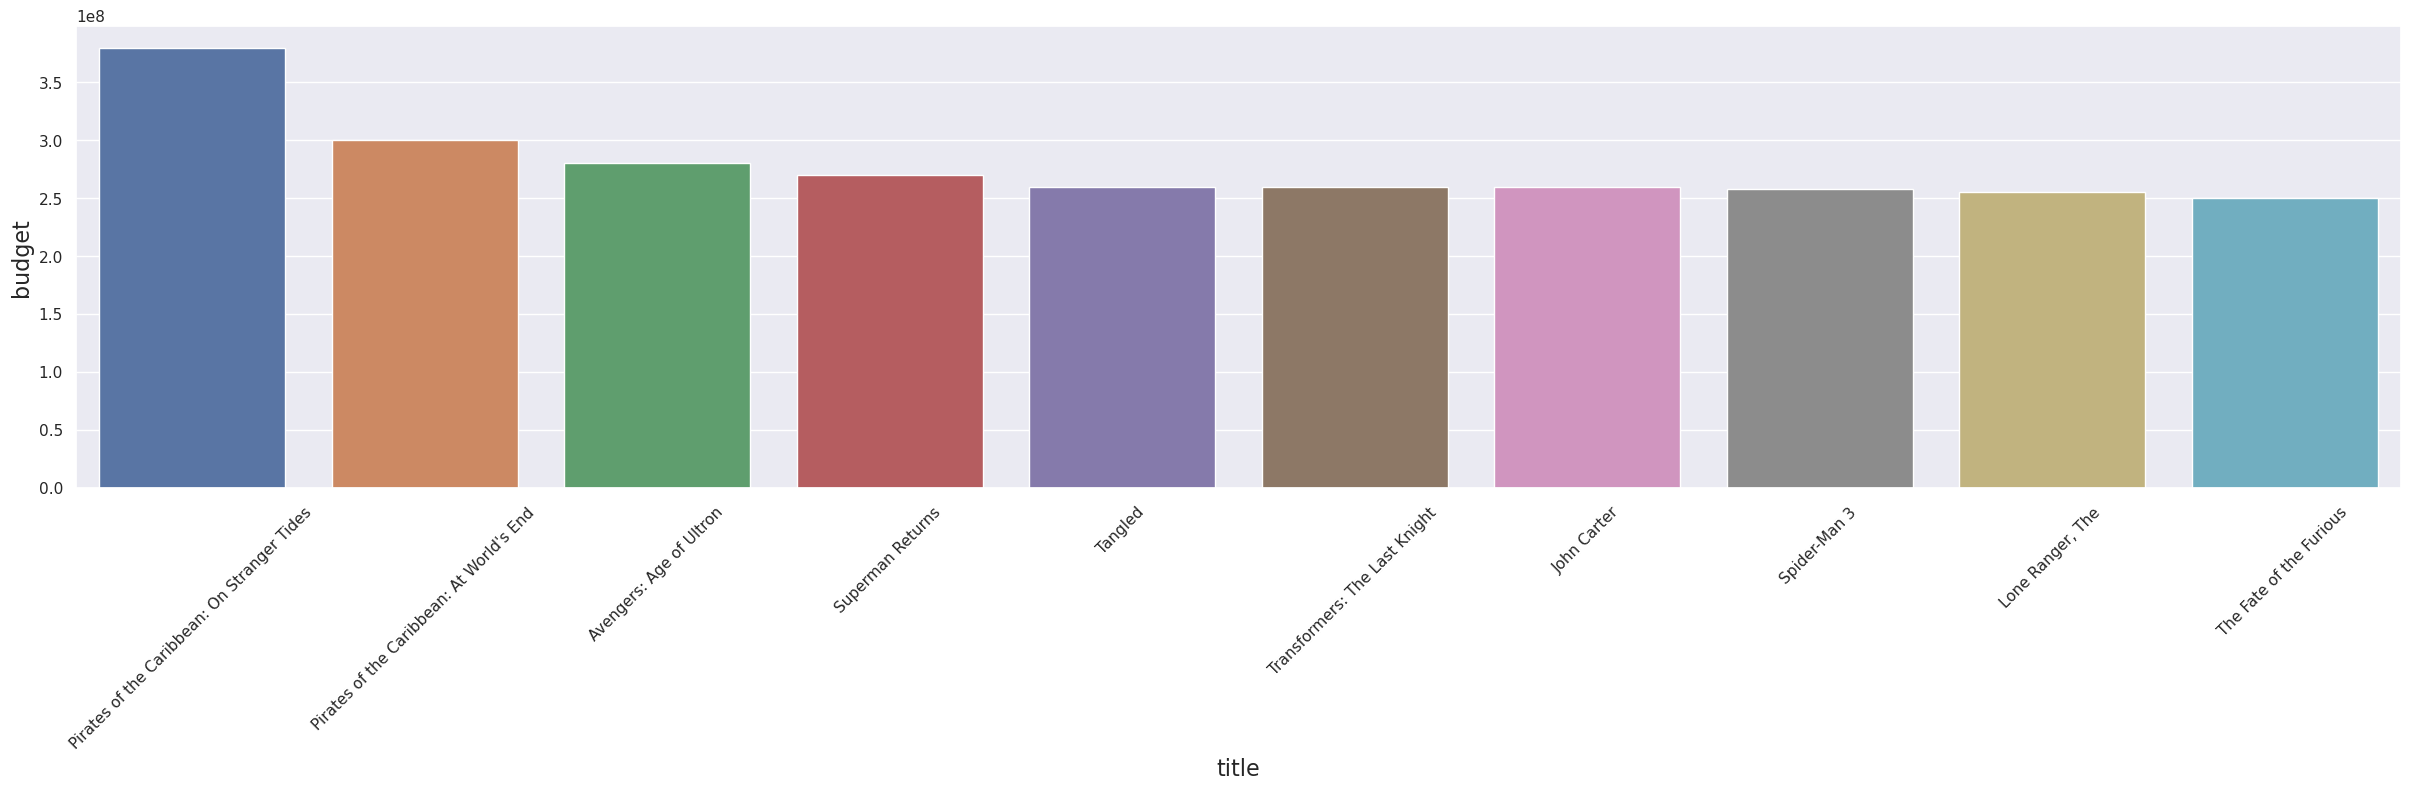

In [58]:
data = movies \
    .sort_values(by=['budget'], ascending=False) \
    [['title', 'budget']] \
    [movies.budget > 0][:10]

pl.barplot(
    data, 
    'title', 
    'budget',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor popularidad?

/var/tmp/ipykernel_3178865/1458916326.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = movies3 \


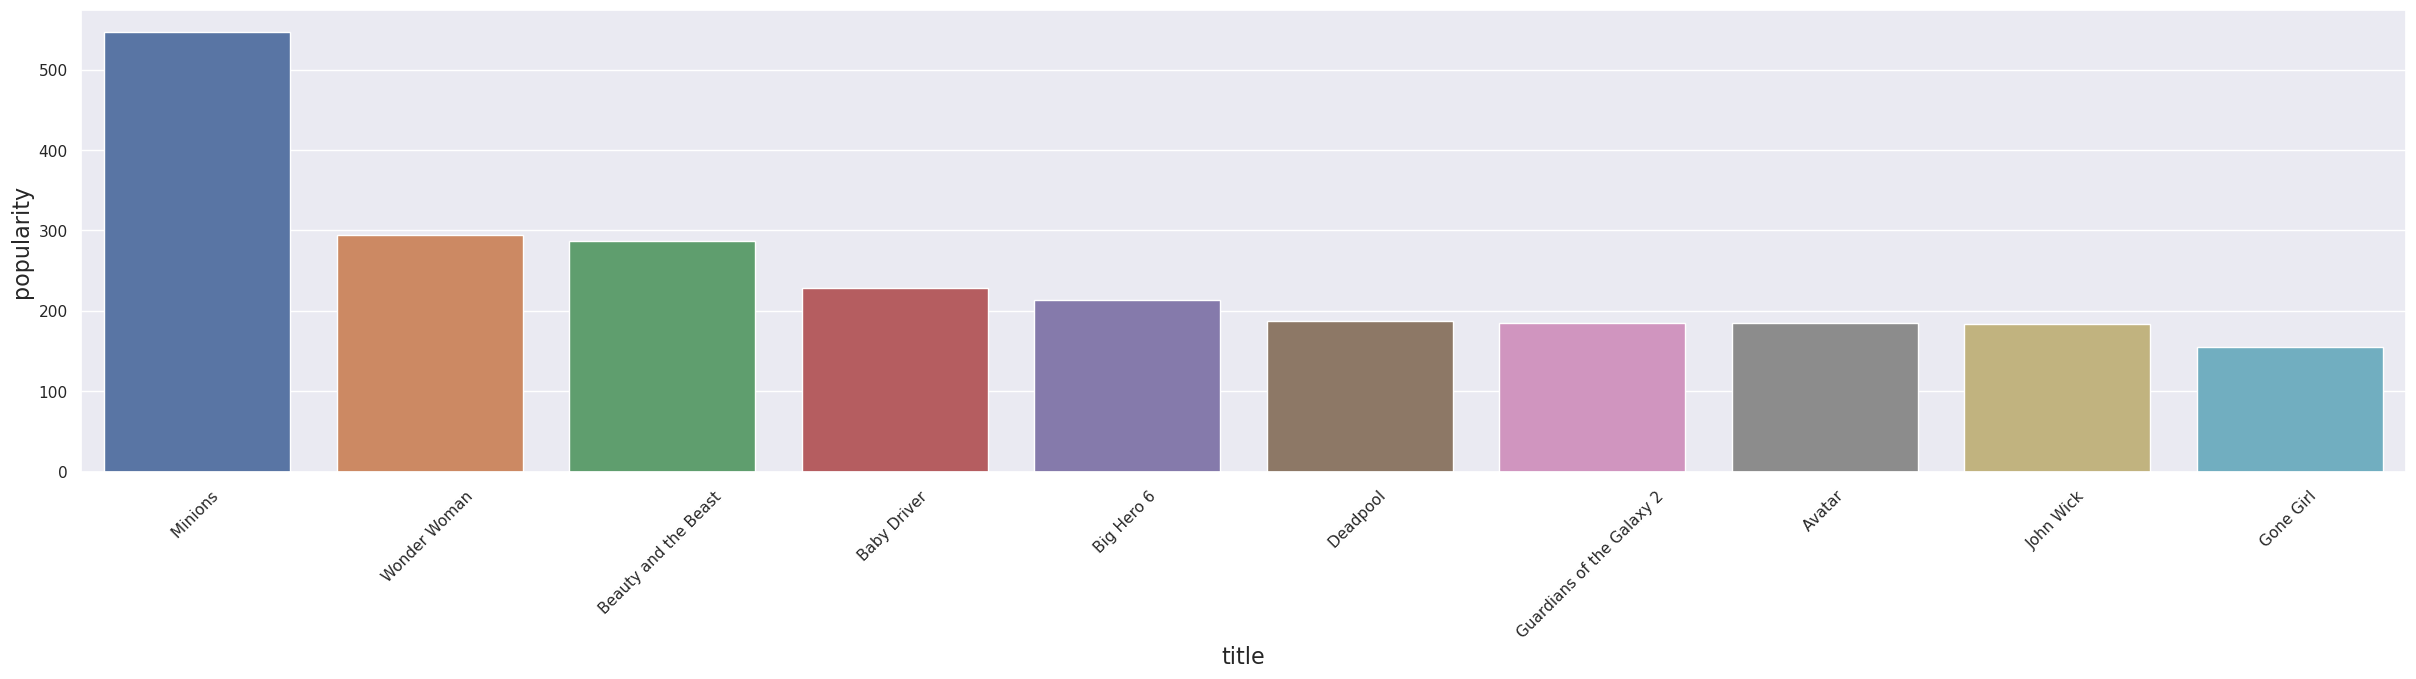

In [59]:
data = movies3 \
    .sort_values(by=['popularity'], ascending=False) \
    [['title', 'popularity']] \
    [movies3.popularity > 0][:10]

pl.barplot(
    data, 
    'title', 
    'popularity',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor promedio de votacion?

/var/tmp/ipykernel_3178865/4246731389.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = movies3 \


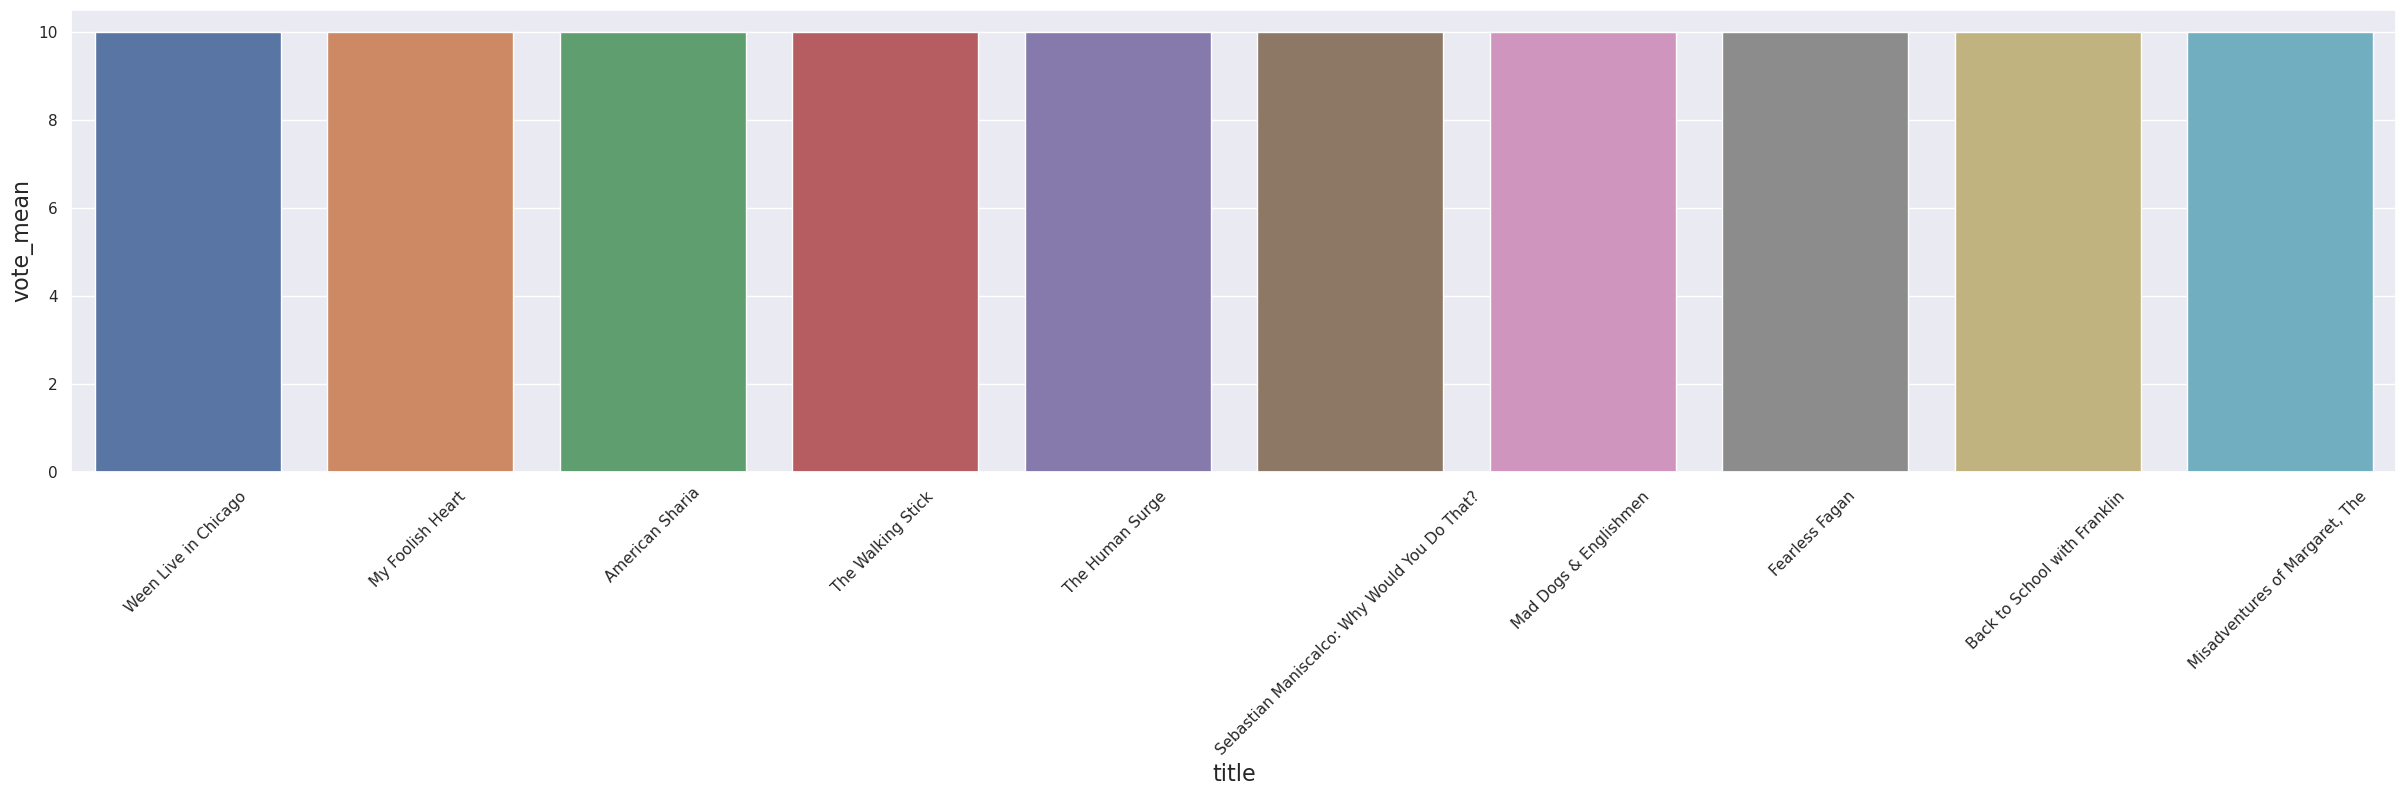

In [60]:
data = movies3 \
    .sort_values(by=['vote_mean'], ascending=False) \
    [['title', 'vote_mean']] \
    [movies3.vote_mean > 0][:10]

pl.barplot(
    data, 
    'title', 
    'vote_mean',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor cantidad de votaciones?

/var/tmp/ipykernel_3178865/1707055543.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = movies3 \


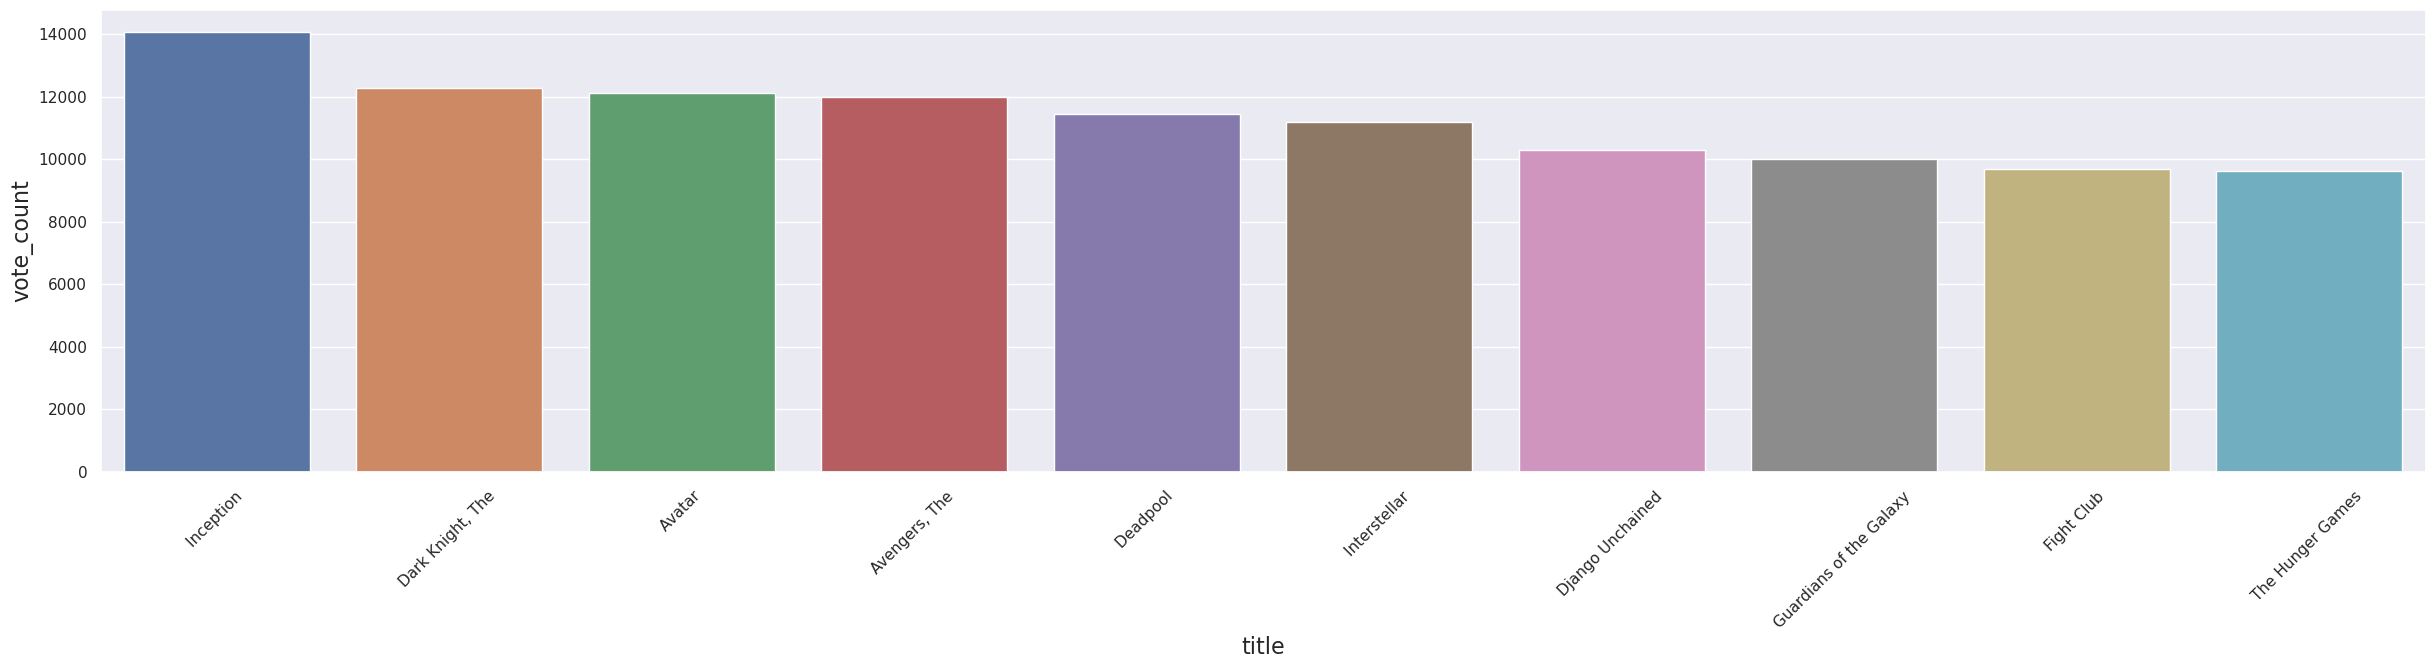

In [61]:
data = movies3 \
    .sort_values(by=['vote_count'], ascending=False) \
    [['title', 'vote_count']] \
    [movies3.vote_mean > 0][:10]

pl.barplot(
    data, 
    'title', 
    'vote_count',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor rating y votaciones?

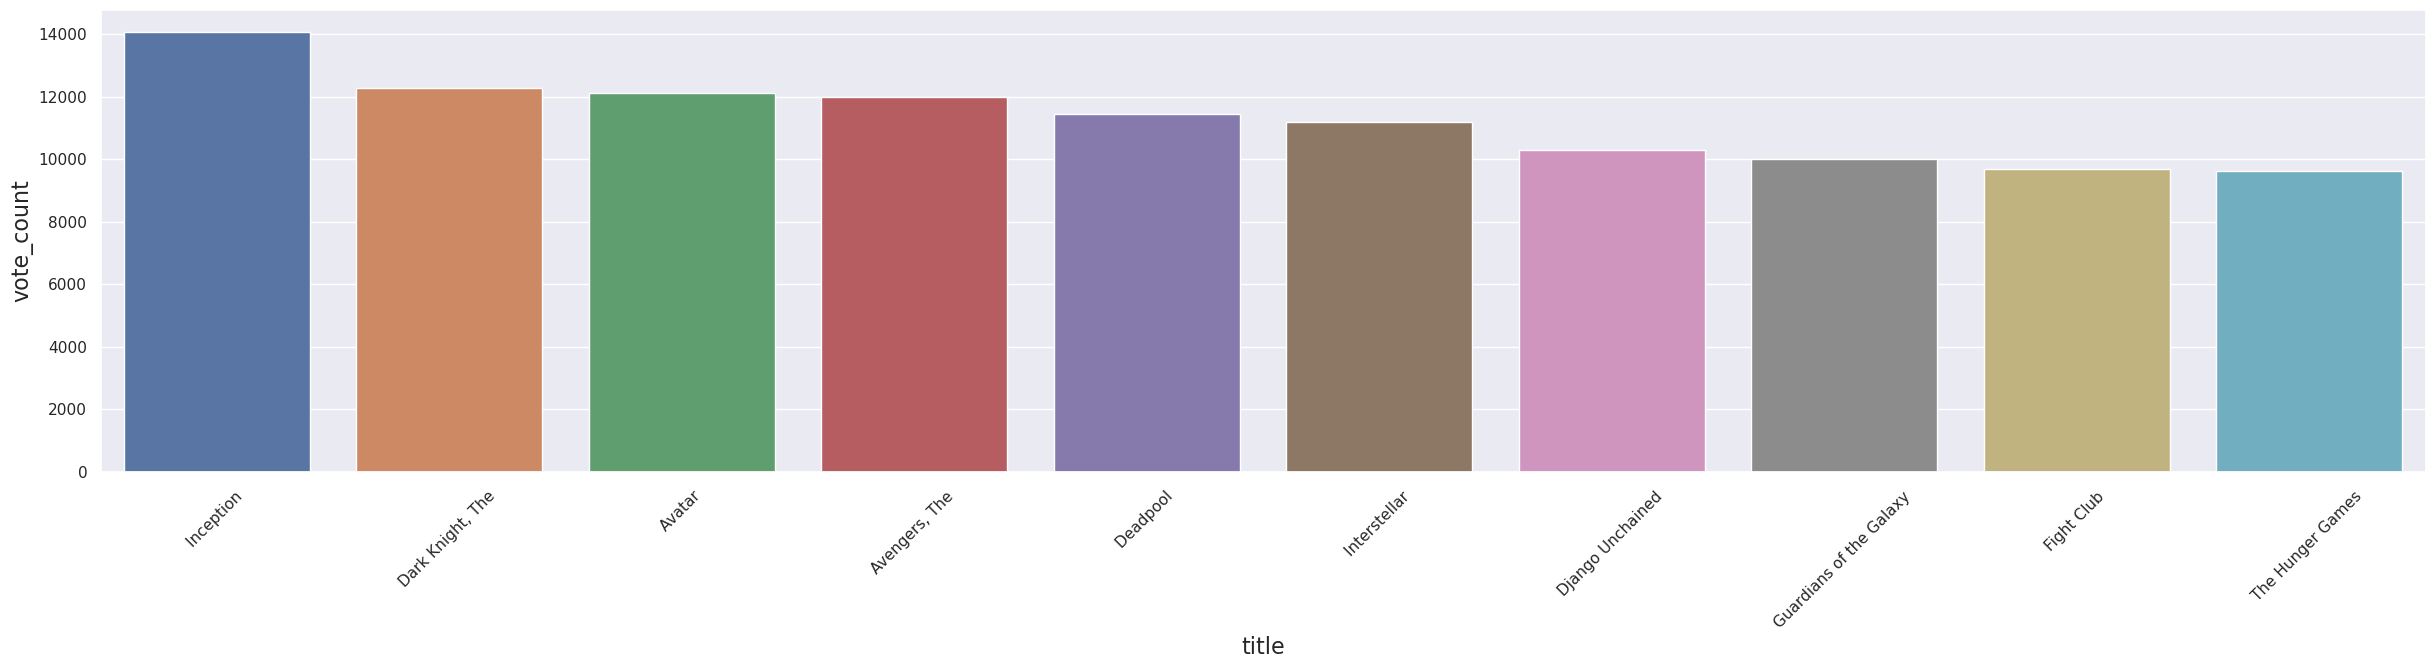

In [62]:
data = pd.merge(
        movies3,
        interactions,
        how='inner',
        left_on=['id'],
        right_on=['movie_id']
    ) \
    .sort_values(by=['rating', 'vote_count'], ascending=False) \
    [['title', 'rating', 'vote_count']] \
    .drop_duplicates() \
    [:10]

pl.barplot(
    data, 
    'title', 
    'vote_count',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor rating y popularidad?

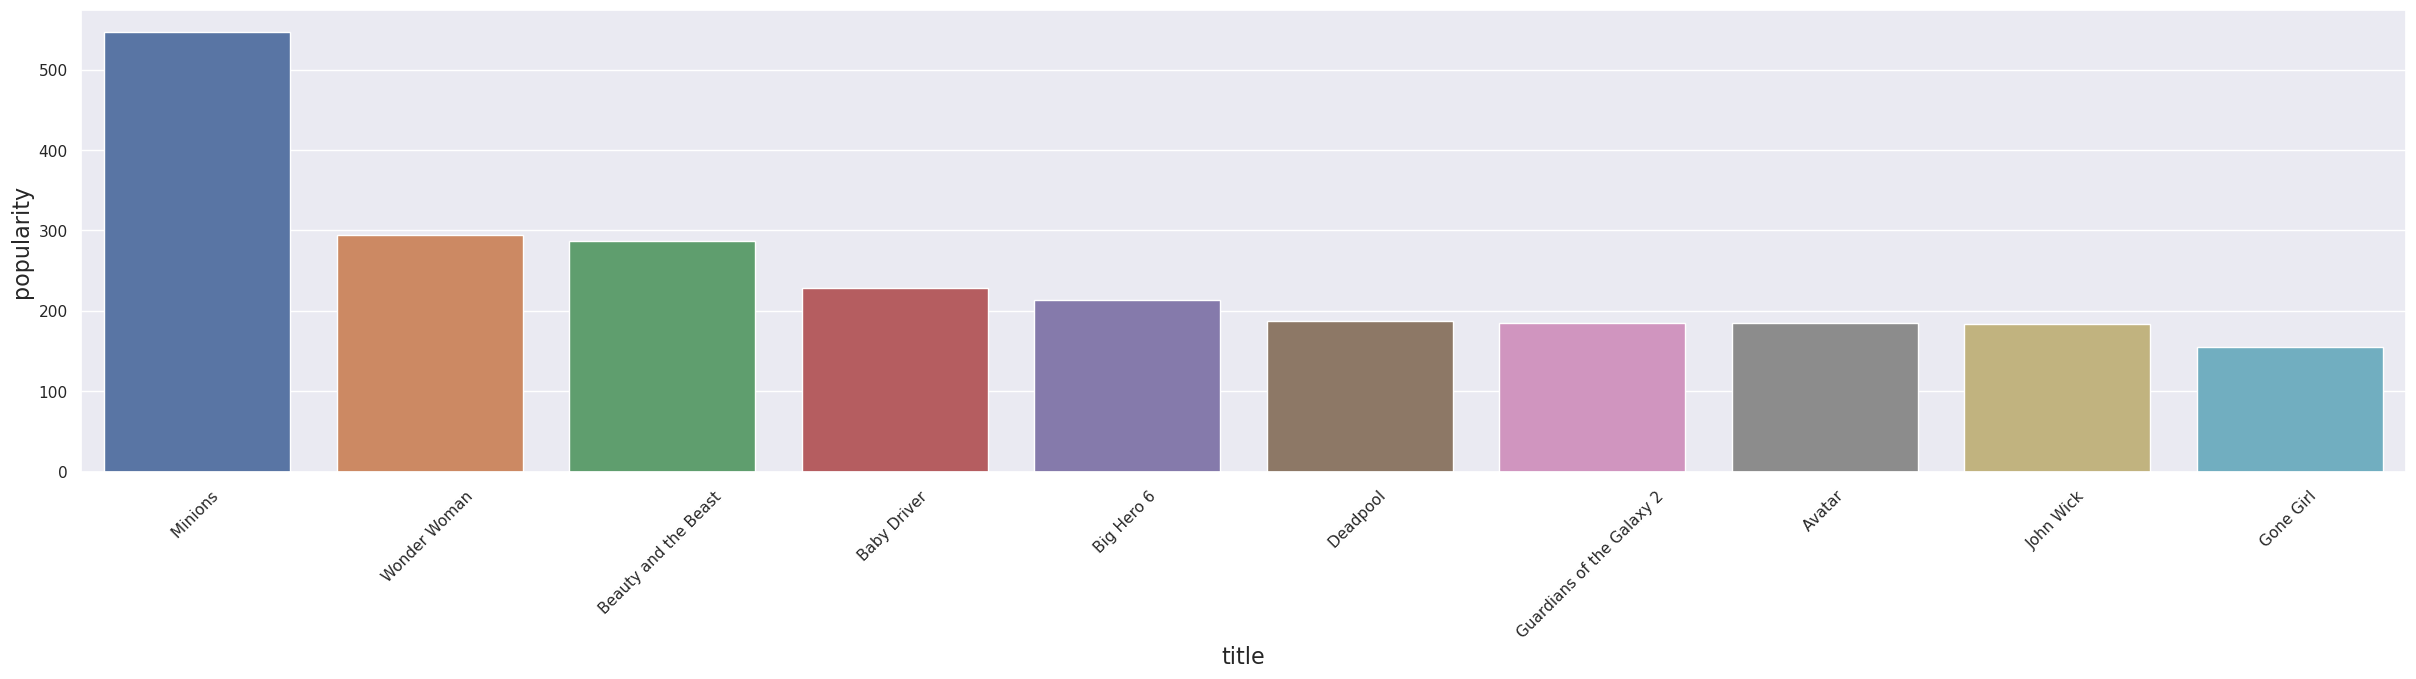

In [63]:
data = pd.merge(
        movies3,
        interactions,
        how='inner',
        left_on=['id'],
        right_on=['movie_id']
    ) \
    .sort_values(by=['rating', 'popularity'], ascending=False) \
    [['title', 'rating', 'popularity']] \
    .drop_duplicates() \
    [:10]

pl.barplot(
    data, 
    'title', 
    'popularity',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cual es la cantidad de peliculas estranada por año para cada genero?

/home/adrian/development/thesis-paper/notebooks/../lib/data/utils.py:56: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data =  df.drop(column, 1).join(df[column].str.join('|').str.get_dummies())


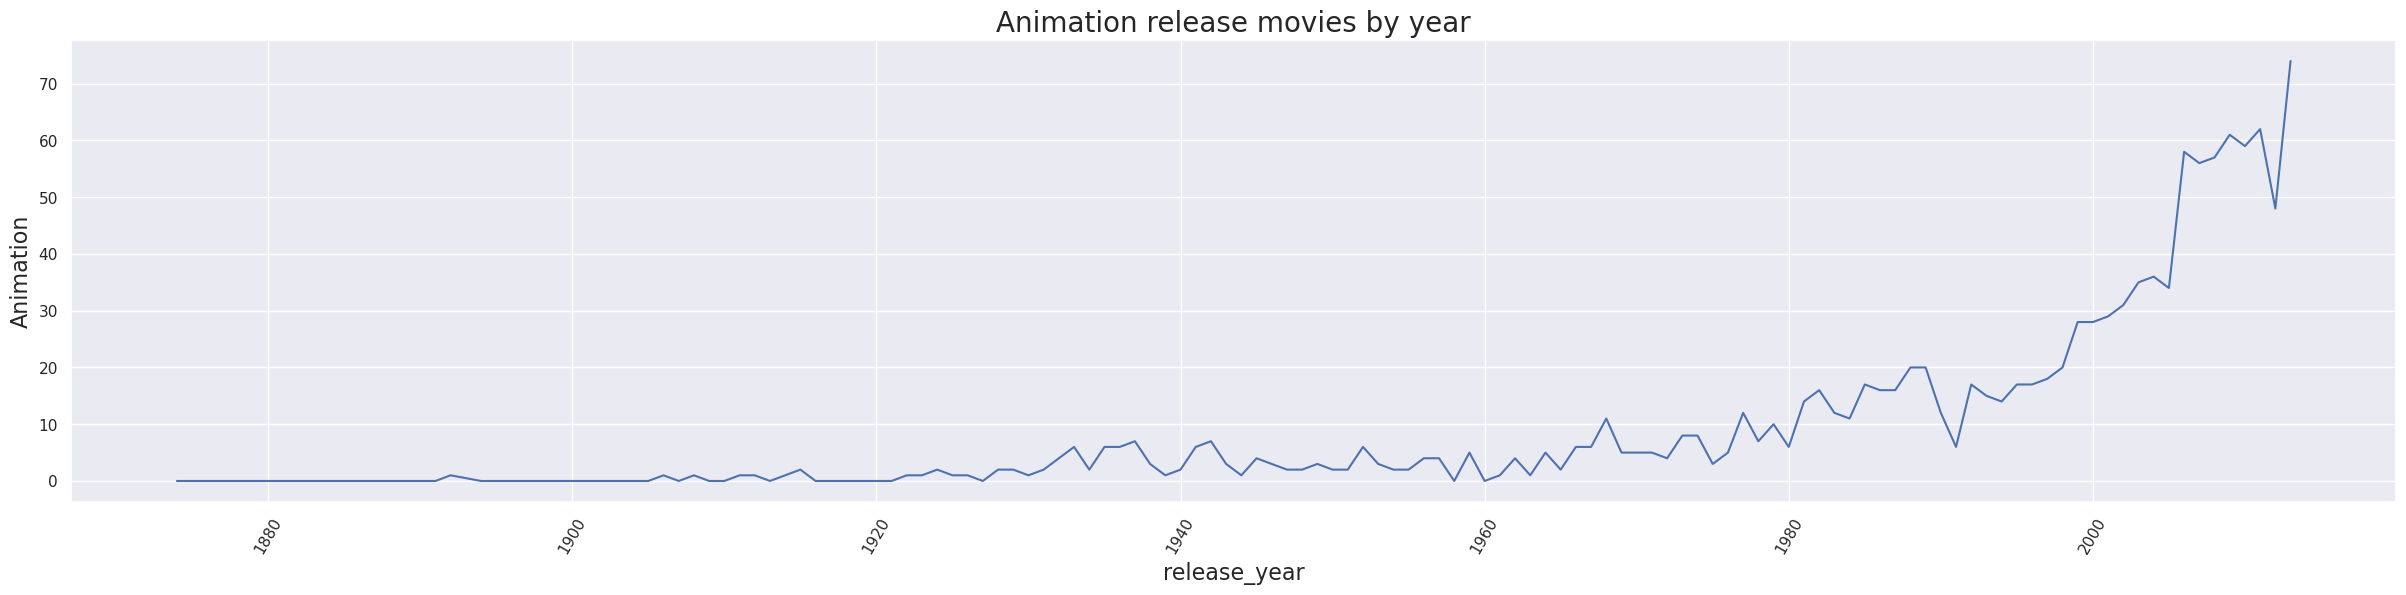

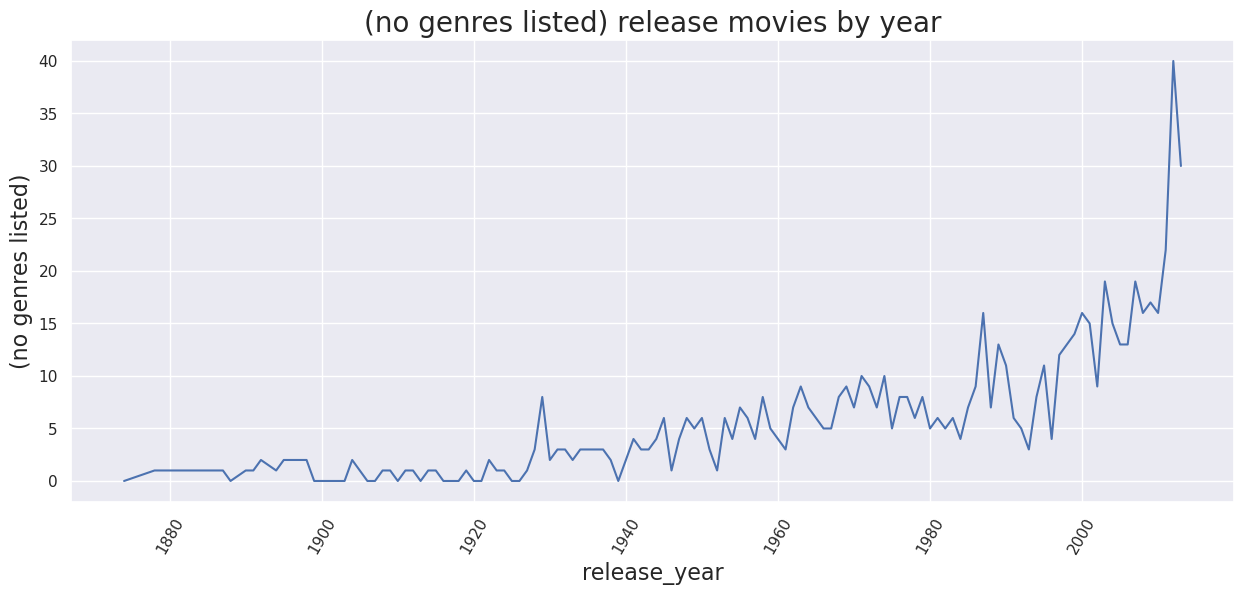

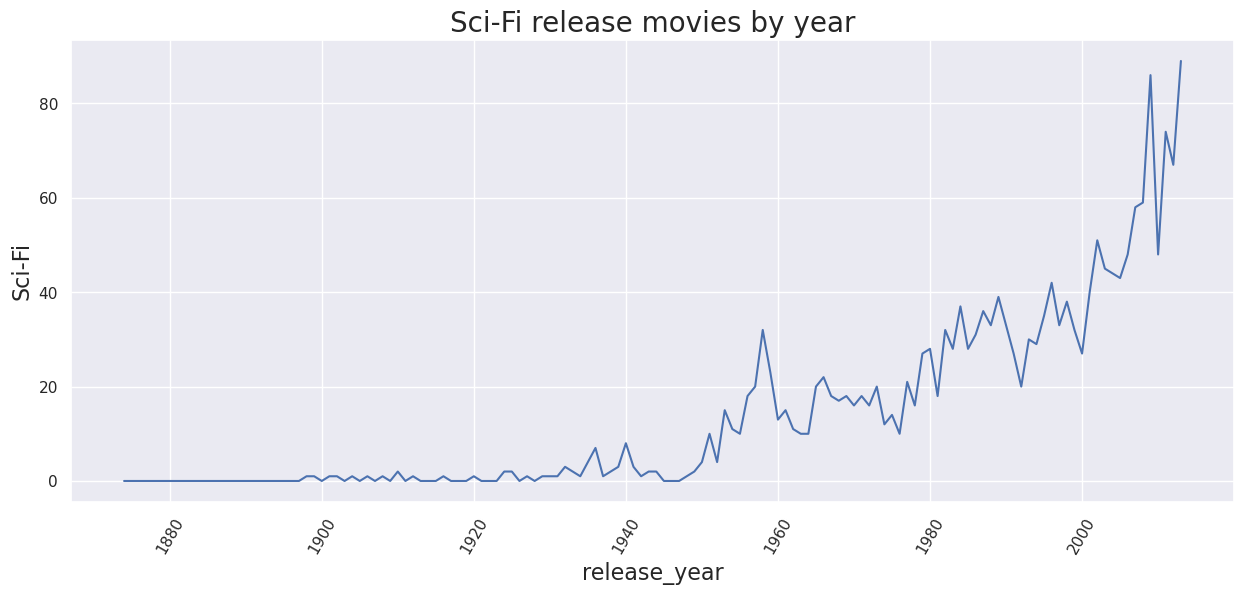

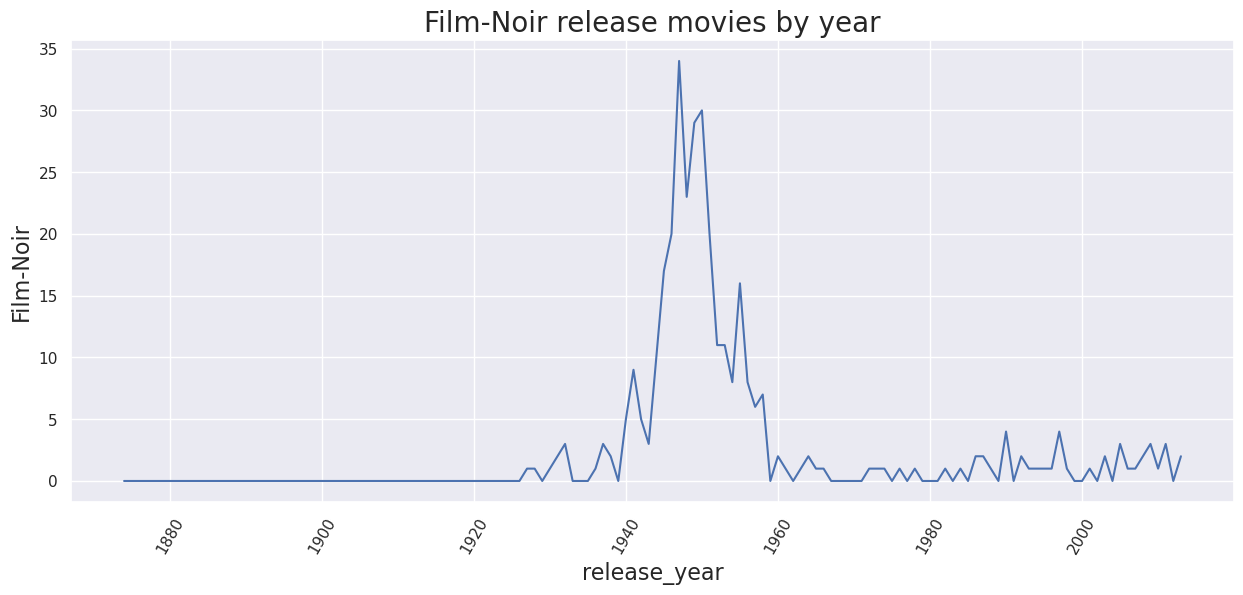

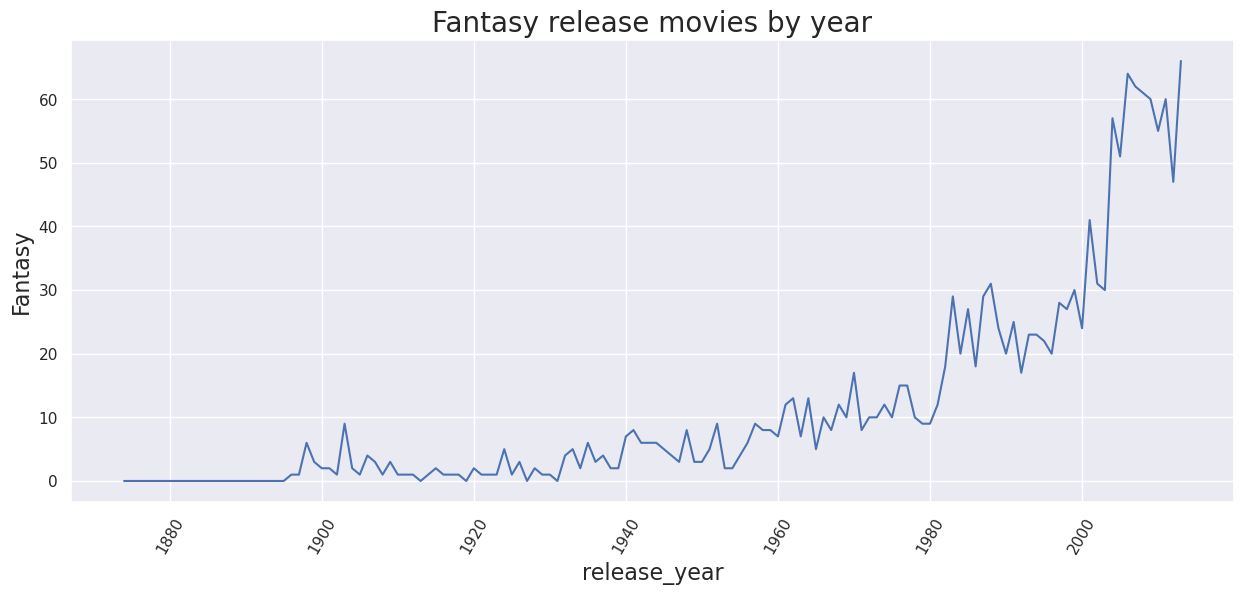

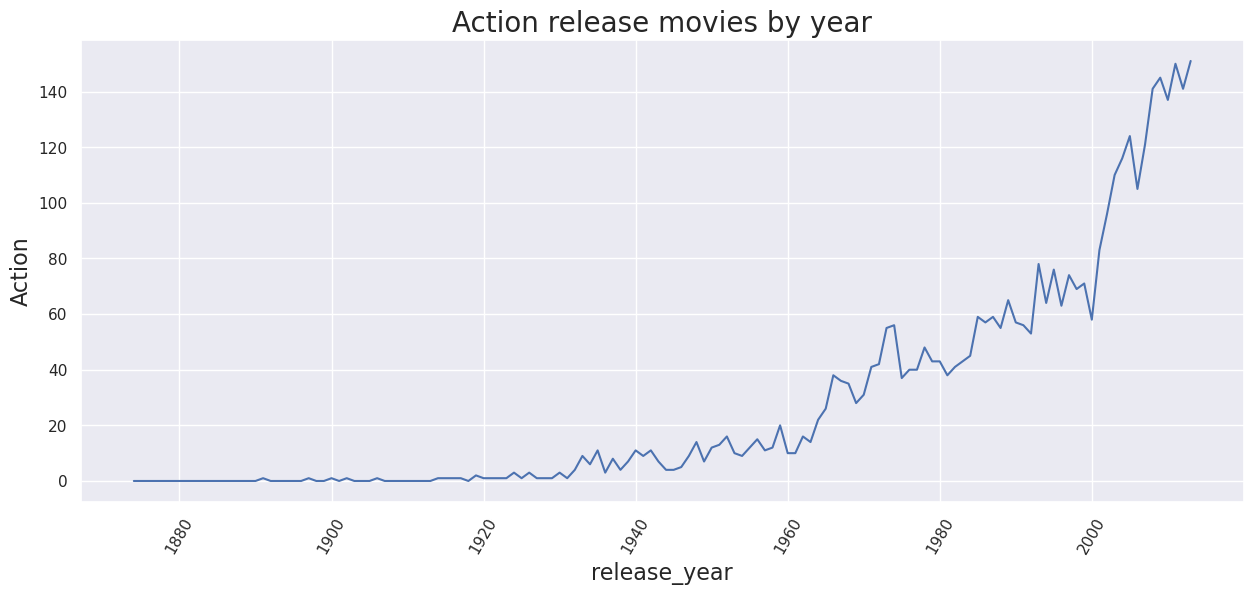

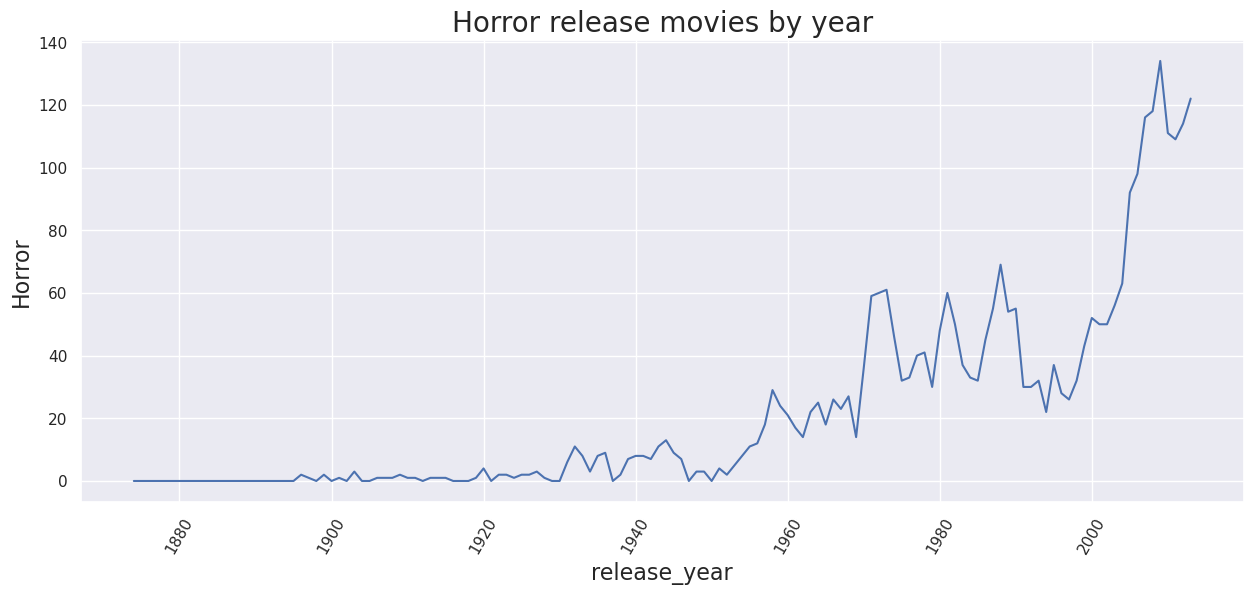

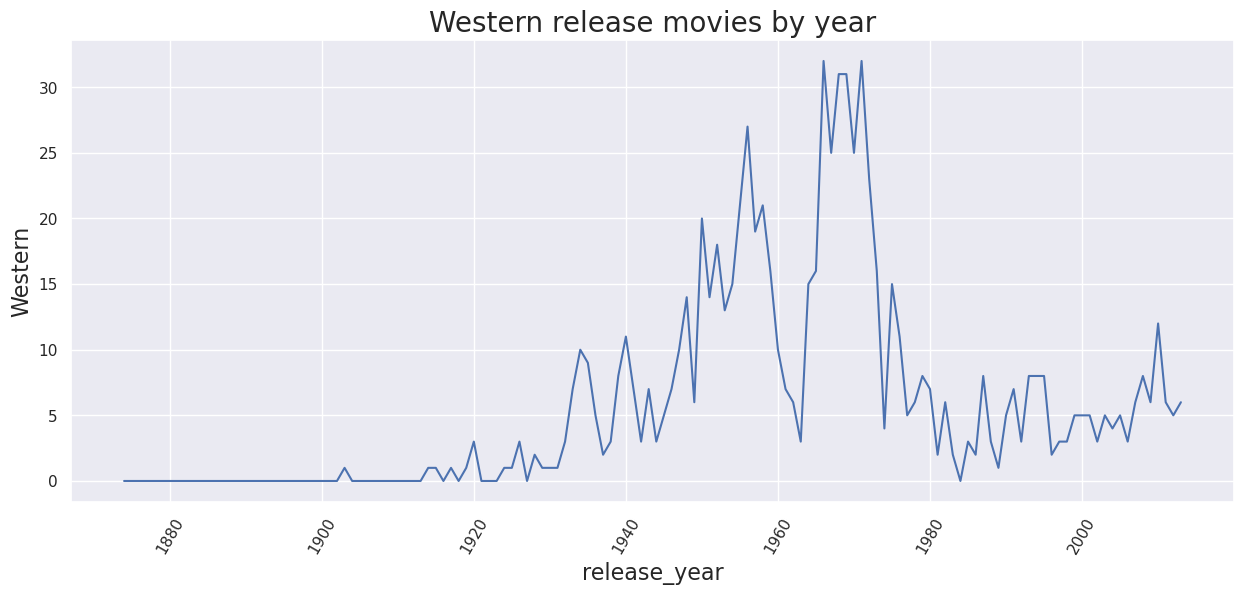

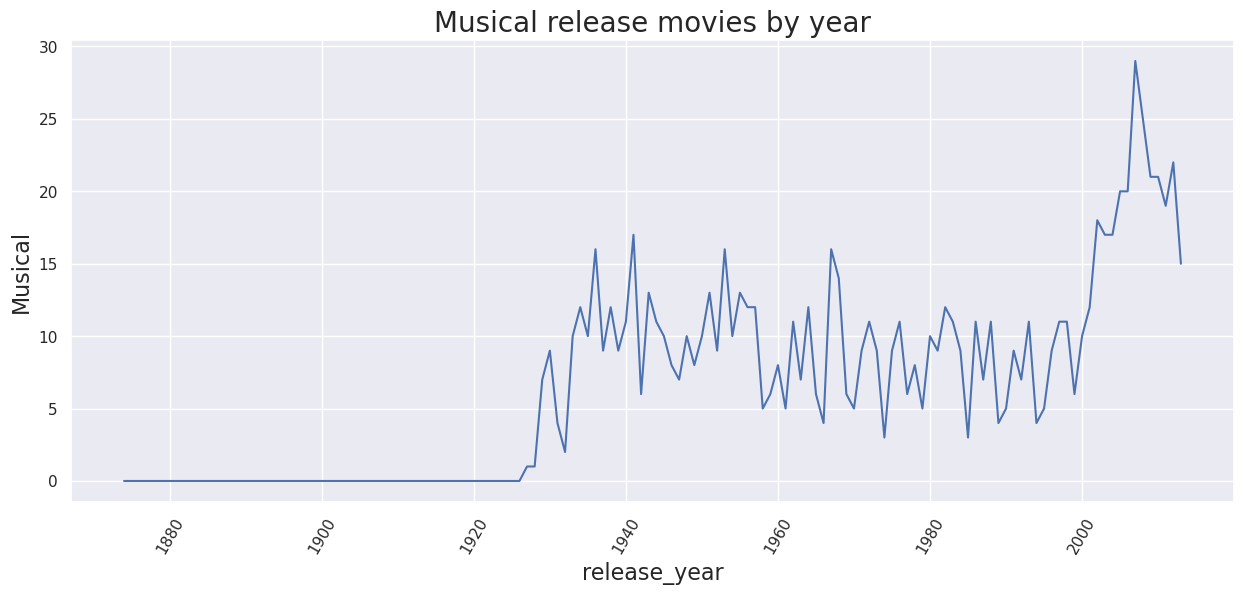

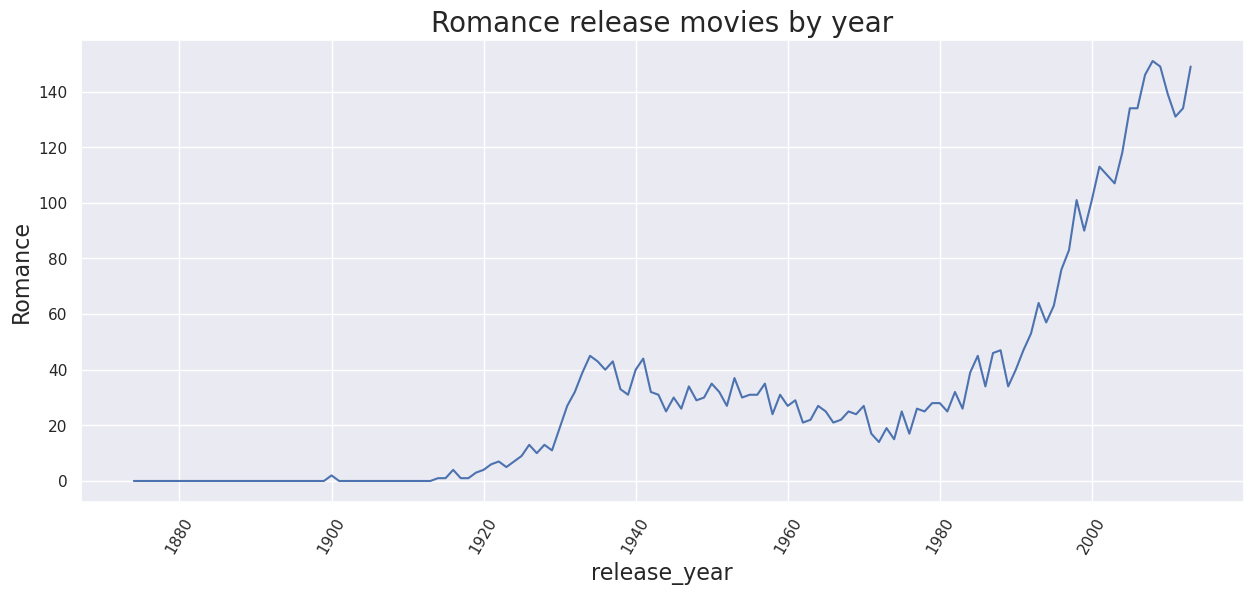

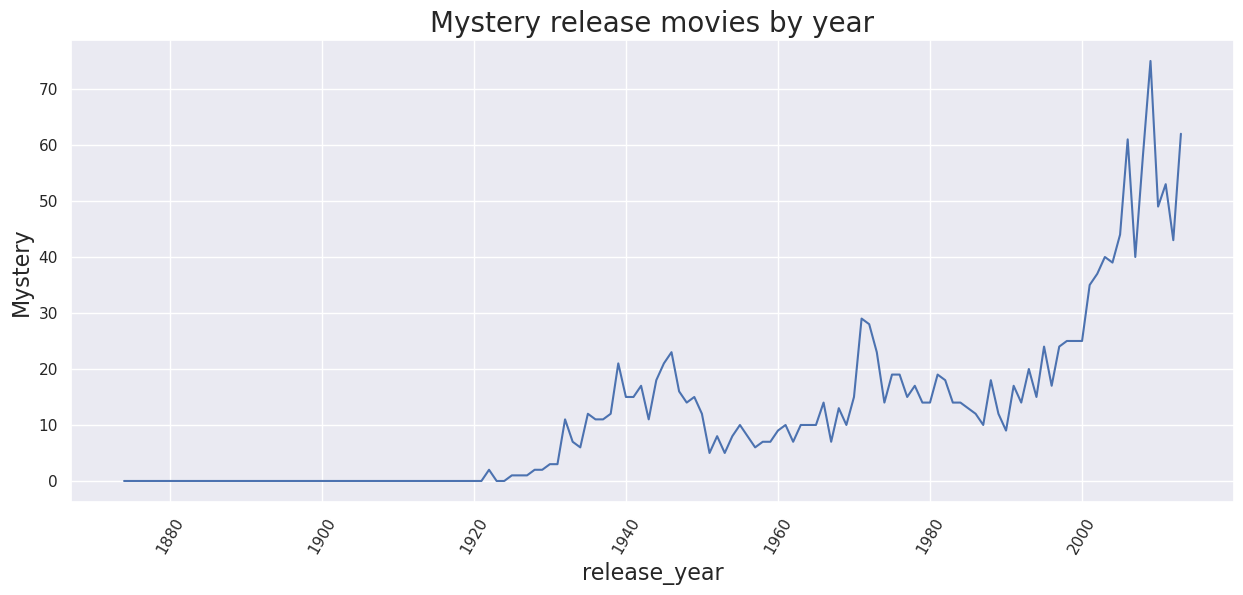

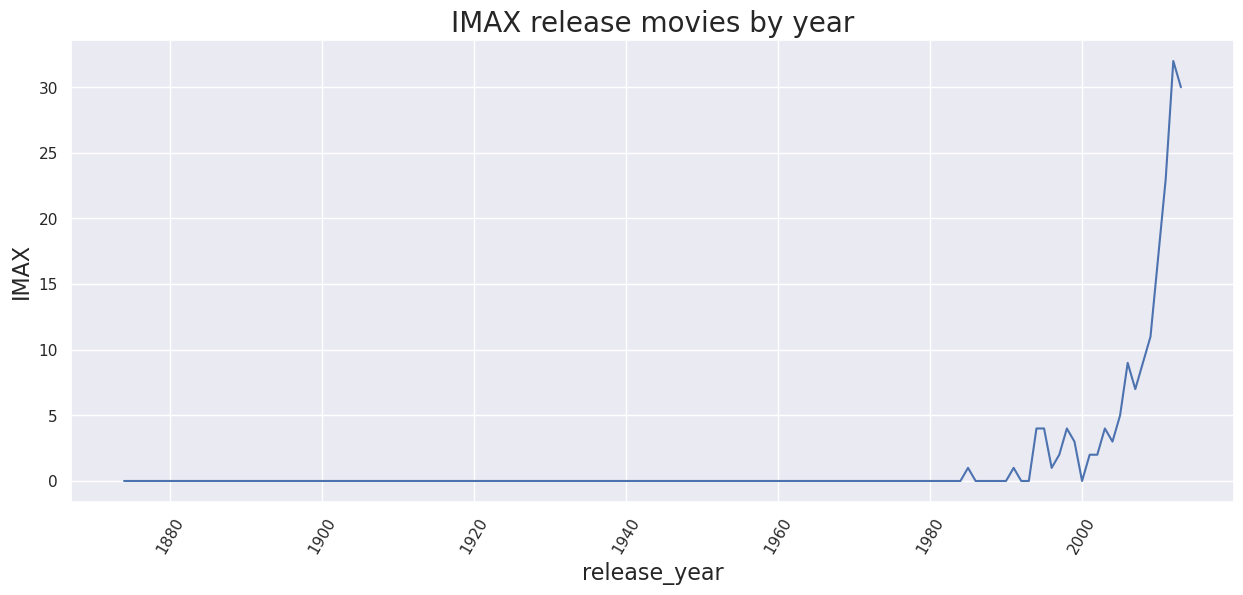

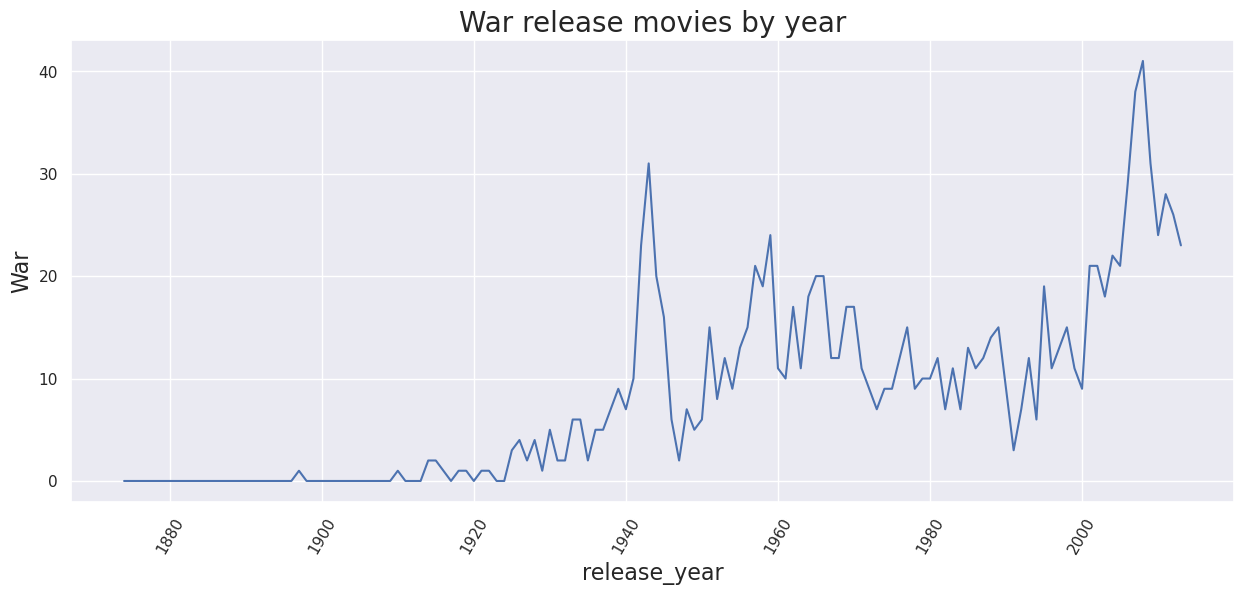

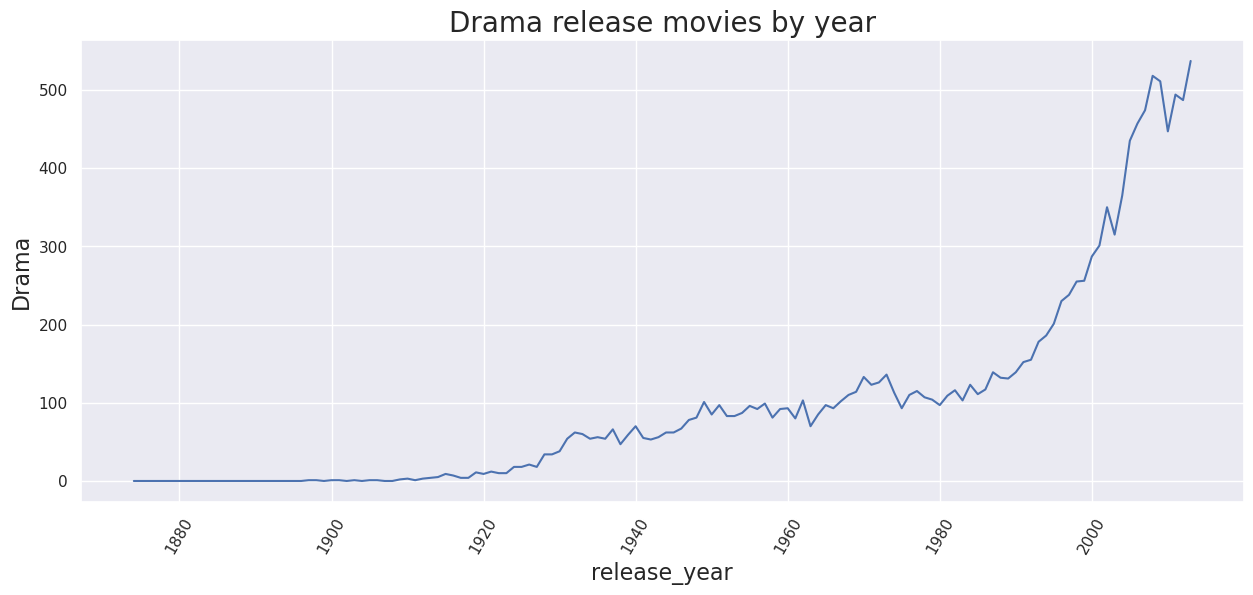

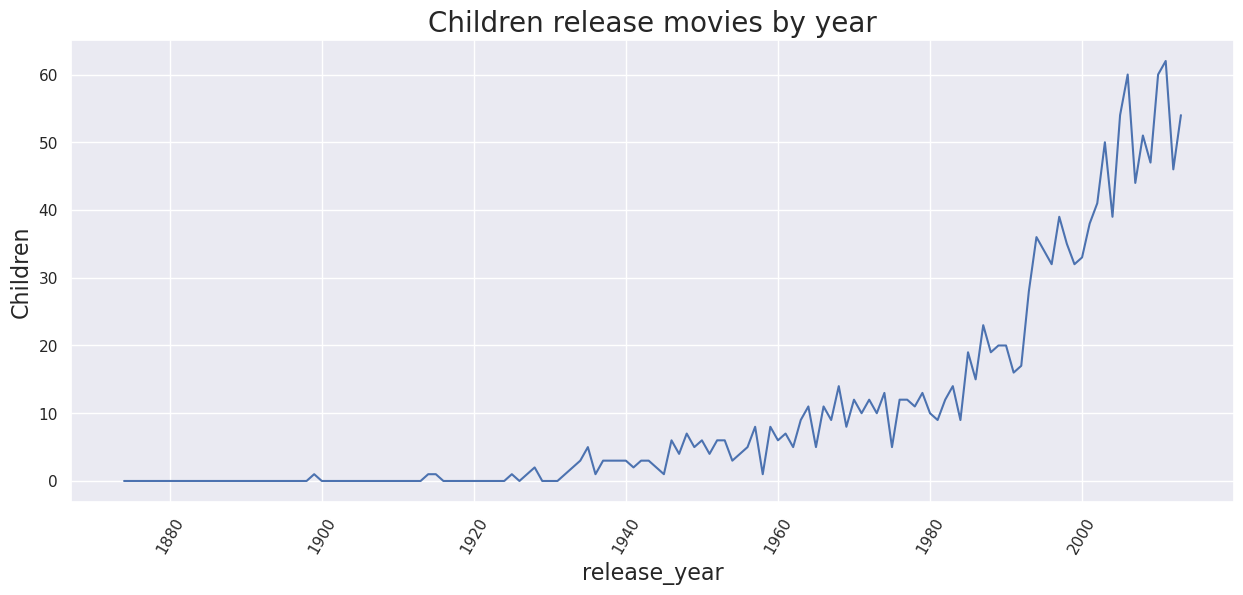

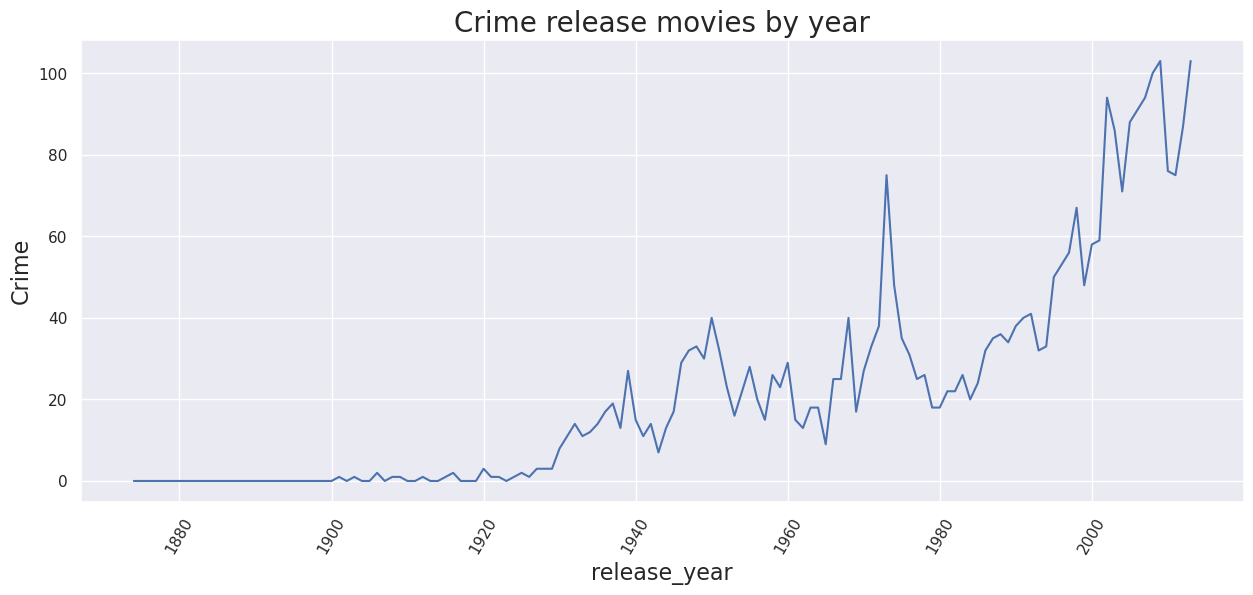

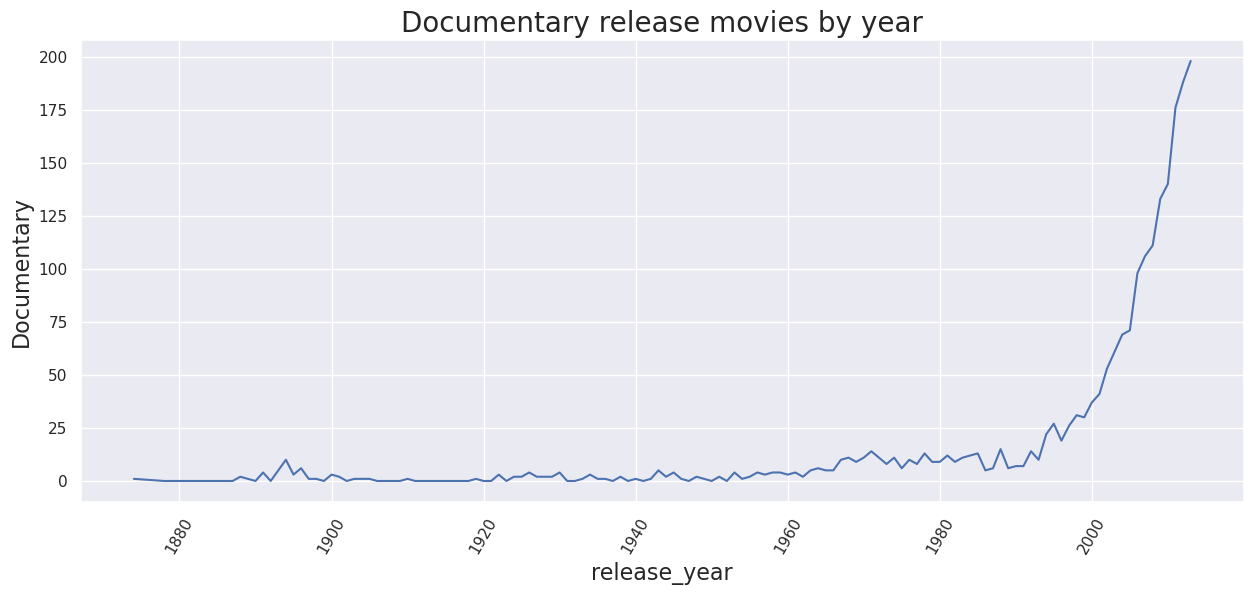

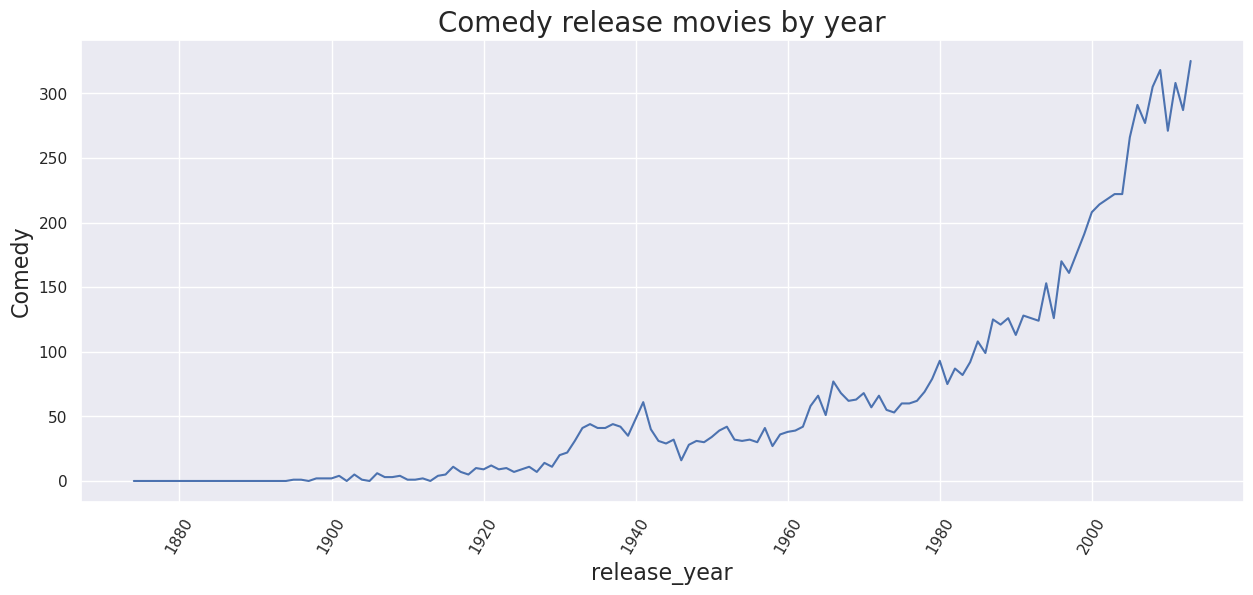

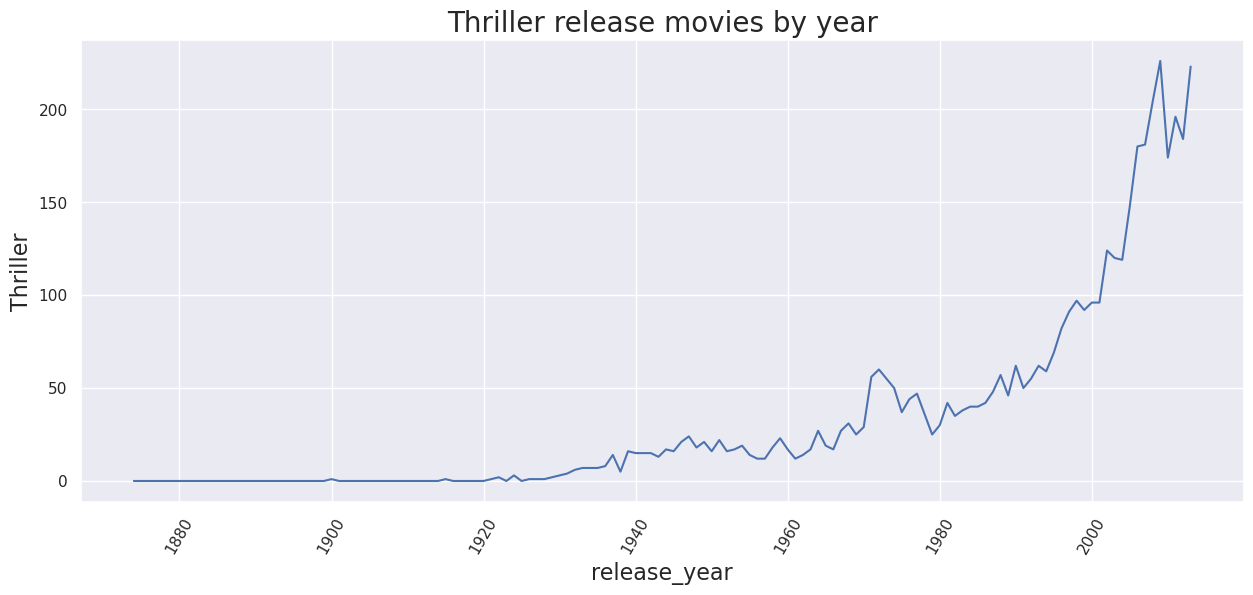

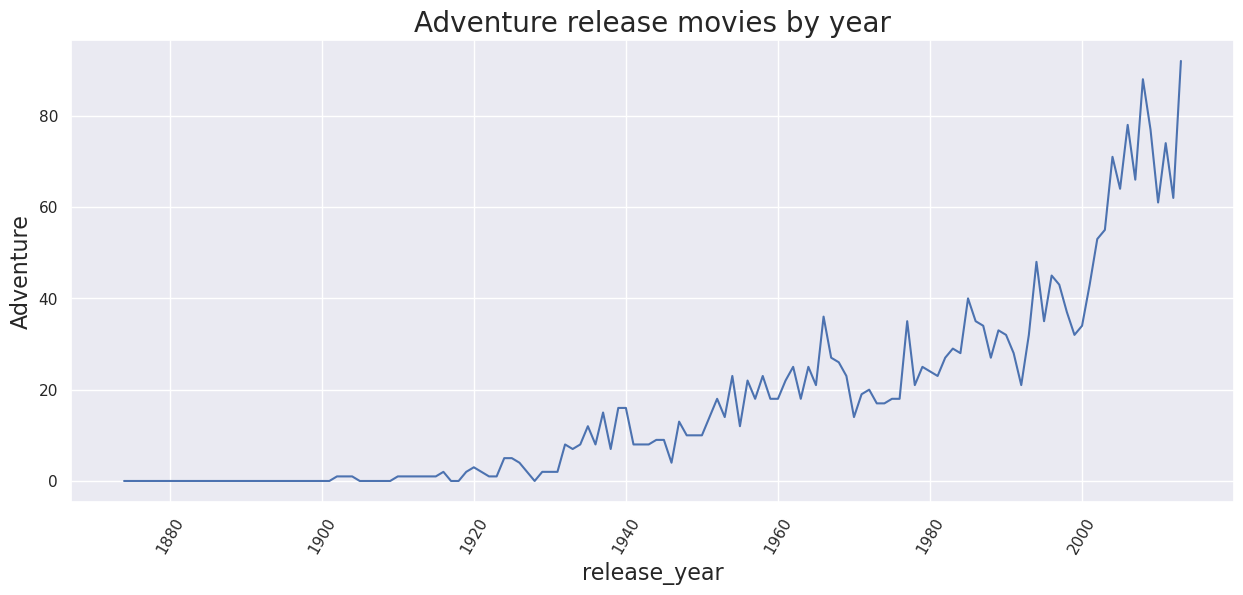

In [64]:
data = dt.list_column_to_dummy_columns(movies3, 'genres')

genres_columns = list(set(data.columns) - set(movies3.columns))

data = data[['release_year'] + genres_columns]

data = data[data['release_year'] <= 2013]


data = data[['release_year'] + genres_columns] \
    .groupby('release_year') \
    [genres_columns] \
    .sum() \
    .sort_values(by='release_year', ascending=True) \
    .reset_index()

[pl.lineplot(data, x='release_year', y=col, title=f'{col} release movies by year') for col in genres_columns]
None

In [65]:
movies3.to_json(f'{DATASETS_PATH}/movies.json')
interactions.to_json(f'{DATASETS_PATH}/interactions.json')

### References

* https://www.kaggle.com/code/amar09/eda-recommendation-model-on-movielens-100k/notebook
* https://jovian.ai/surendranjagadeesh/movielens-eda